# NOTE: Kaggle really struggles to render Markdown in the "View Notebook" mode (does not handle ## seactions)
I tried with Colab, but it struggles in a different way - it can't handle block formulas.

If you want to view the notebook properly, please see https://github.com/xl0/gemini-pdf-converter/blob/master/pdf-converter.ipynb

If you want to run the notebook and use the UI to convert your PDFs to markdown,
please clone https://github.com/xl0/gemini-pdf-converter and run it locally.

Copy .env.example to .env and set your Gemini API key in it.


## Converting PDF documents to Markdown with Google Gemini

<img src="https://github.com/xl0/gemini-pdf-converter/blob/master/assets/is_all_you_need.png?raw=true" width="400" style="display: inline" />
<img src="https://github.com/xl0/gemini-pdf-converter/blob/master/assets/lowry.png?raw=true" width="300" style="display: inline" />


### The problem

Unlike Madkdown or HTML, the data in a PDF page does not always come in the natural order. 
It's more like a canvas, with a list of elements like:
- `("World", font, location, transforms, ...)`
- `("Hello", font, location, transforms, ...)`
- `([Image], location, transforms, ...)`

that are placed at the correct location during rendering. It's generally not possible to reliably extract text  
in the natural order, and it gets especially messy with formulas:

![Attention](https://github.com/xl0/gemini-pdf-converter/blob/master/assets/attention.png?raw=true)
```
In practice, we compute the attention function on a set of queries simultaneously, packed together | {...}
into a matrix | {...}
 Q | {...}
. The keys and values are also packed together into matrices | {...}
 K | {...}
 and | {...}
 V | {...}
 . We compute | {...}
the matrix of outputs as: | {...}
Attention( | {...}
Q, K, V | {...}
 ) = softmax( | {...}
QK | {...}
T | {...}
√ | {...}
d | {...}
k | {...}
) | {...}
V | {...}
(1) | {...}
```

On top of this, many older PDFs are scanned paper documents, and contain poorly  
recognized text, no text at all, full-page images instead of text, or images of page fragments.

Especially for a scanned PDF, we need to use AI to correctly extract the text  
and image from the document.

### Procedure

- Extract text and image from the document
- 🤖 Ask Gemini if the images look good.
    - If the images look good, we don't need to do the extra extraction step.
    - If they don't look good:
        - 🤖 Use Gemini to find bounding boxes for all images in the page.
        - Extract images from the bounding boxes.
 - 🤖 Give the page image, extracted text, and extracted images to Gemini, and generate markdown with references to images.
- Combine the markdown for all pages into a single document.
- 🤖 Pass the full document to Gemini and ask it to brush up the formatting to make it consistent across pages.
    - This step requires multi-step generation and context caching.
- Save the resulting markdown and images.

### Long context
During the second pass, we need to pass the whole document (text only) through Gemini Flash again, to fix small conversation errors and inconsistencies. We break the 100K token barrier at around 60-80 pages for a typical research paper, depending on the text density. 

### Caching

During the second pass, the input text is cached, as multiple calls to the model are required in order to re-generate the complete document.


### UI
There us a UI at the end of the notebok. Run the notebook (with `RUN_DEV_CELLS=False` for speed) and use it to convert your PDFs:

<img src="https://github.com/xl0/gemini-pdf-converter/blob/master/assets/ui.png?raw=true" width="400" />

### API key
Set `GEMINI_API_KEY="your very secret key"` in the environment

### Findings

Durig this fun projects I found:
- Gemini works best with simple and concise tasks. Initially I tried to combine multiple tasks into one step, and the model was struggling.
- Gemini is able to find figures/plots/images in a PDF page, but it's not 100% reliable on its own.
- Gemini is excellent at converting between plain text and different text-based formats.

#### 🚩🥽 Recitation error
Gemini will fail with finish reason: `RECITATION` that triggers when the model is generating large chunks of  
material from some Google's database, regardless of license. This of couse makes using Gemini for format  
conversion challenging, as the generated text will often match large chunks of known material.

**GOOGLE: Pretty please, allow recitation if the recited material is also fully/largely present in the models input!**

Luckily, this mechanism can be fooled easily. I ask the model to insert `[<end of paragraph>]` after every paragraph, and cut them out later. This seems to be enough to avoid this error.


#### GitHub
Ready to run code is available at https://github.com/xl0/gemini-pdf-converter

---

### There are two ways to run this notebook
#### `RUN_DEV_CELLS=True` - will test the functions as I did during development, this is rather slow. Enable it to follow the inner works.
#### `RUN_DEV_CELLS=False` - runs vert fast and you can use the UI at the end of the notebook to convert your PDFs into markdown!

### `RUN_SUPER_LONG_CONTEXT` - This will run the very long ( > 100K) token demonstration, and takes a long time.

In [40]:
RUN_DEV_CELLS=True

# There is an example that demonstrates the use of long context. It takes a particularly long time to run.
# Keep this one as False unless you are sure.
RUN_SUPER_LONG_CONTEXT=True

# Gemini Flash is good for most sub-tasks, while other require a mode capable Gemini Pro.

## The 2 model names are gemini-1.5-flash-002 and gemini-1.5-pro-002
## The numeric version is required for the cache, because cache can not be shared between sub-versions of the model.

IMAGE_CHECK_MODEL="gemini-1.5-pro-002"
IMAGE_EXTRACTION_MODEL="gemini-1.5-pro-002"
PAGE_TO_MARKDOWN_MODEL="gemini-1.5-pro-002"
SECOND_PASS_MODEL="gemini-1.5-flash-002" # Use flash for the second pass - the task is simple.

In [41]:
import os

IN_KAGGLE=False
if "KAGGLE_URL_BASE" in os.environ: IN_KAGGLE=True

if IN_KAGGLE:
    !pip install -U pymupdf -q
    # Copy over the files and image assets.
    !cp -a /kaggle/input/* .
    
    
    # Display images inline (default) to oveeride Kaggle styling.
    # Display summary (<details>) correctly in Kaggle.
    from IPython.display import display, Markdown, HTML
    
    style="""
    <style>
    .jp-RenderedHTMLCommon > img {
        display: inline!important;
    }

    summary {
        display: list-item!important;
    }
    
    </style>
    """
    display(HTML(style))
else:
    !pip install -qU pymupdf fastprogress ipywidgets google-generativeai

In [42]:
if IN_KAGGLE:
    from kaggle_secrets import UserSecretsClient
    api_key=UserSecretsClient().get_secret("GEMINI_API_KEY")

    # I tried using fastprogress because tqdm is broke in Kaggle, but fastpregress is also broken in View Notebook mode.
    # Replace it with a fake progress bar that does nothing, to avoid breaking notebook preview.
    def progress_bar(obj, *args, **kwargs):

        class FakeBar:
            def __init__(self, obj):
                self.obj = obj
                self.total = float("+inf")
            
            def update(self, val):
                self.last_v = val

            def __iter__(self):
                for o in self.obj: yield o
    
        return FakeBar(obj)

else:    
    # I'll still use fastprogress it in non-kaggle mode, because I don't want to rewrite the code back to tqdm.
    from fastprogress.fastprogress import progress_bar 
    from dotenv import load_dotenv
    load_dotenv()
    api_key = os.environ["GEMINI_API_KEY"]

In [43]:
import io
import re

import fitz
from PIL import Image
import os
import shutil

# from tqdm.auto import tqdm

import google.generativeai as genai
from google.generativeai.types import HarmCategory, HarmBlockThreshold, RequestOptions
from google.generativeai.types.content_types import to_part
from google.generativeai.protos import Candidate
from google.generativeai import caching
from google.api_core import retry

genai.configure(api_key=api_key)

import datetime

from typing import Any

from time import sleep
from dataclasses import dataclass, field
import random
import string
from IPython.display import Markdown
from pathlib import Path
import warnings

import json
from typing_extensions import TypedDict

In [44]:
# Gemini is a bit trigger-happy on the filters, and some research papers might get flagged.
SAFETY_SETTINGS = {
    HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
    HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
}


# We have 2 types of retries, as the Gemini API has proven to be flaky.

# One retry strategy internal to the Gemini SDK for when the request returns with a failure
def retry_predicate(exception):
    print(f"Retry on exception {exception}")
    sleep(5) # I found this extra 5 seconds helps - Gemini API can get stuck otherwise ಠ_ಠ.
    return True

# Gemini fails quite often. Retry on failures.
request_options=RequestOptions(retry=retry.Retry(predicate=retry_predicate, initial=5, multiplier=2, maximum=5*60, timeout=20*60))

# Sometimes the request will finish successfully, but the response will be empty (no candidates).
# In this case we will also retry the request with exponential backoff.

MAX_RETRIES=5

# Gemini has another annoying feature - it detects when the genreatio is reciting "cipyrighted content",
# which you'd expect would happen all the time when converting a PDF to markdown.

# Surprisingly, it only triggers infrequently and rather randomly, even with temperature=0,
# and does not trigger if I retry the exact same request.

# I also noticed that it's often enough to retry the offending request, even with temperature=0, top_k=1, so
# we will also retry those, in case some RECITATION sneaks through.

# GOOGLE: Please fix your stuff. :/

In [45]:
@dataclass
class PDFImage:
    image: Image.Image
    name: str
    bbox: list[int] = field(default_factory=list)  # For images we extract later, keep the bbox.
    export: bool = False                           # Export images will be saved as files.

@dataclass
class PDFPage:
    page_num: int
    extracted_text: str;
    page_image: Image.Image
    extracted_images: list[PDFImage];

    # Used to keep track of intermediate steps for debugging.
    extracted_images_analyzed: Any = field(default_factory=dict);
    images_proposed: list[Any] = field(default_factory=list);

    markdown: str = "";

@dataclass
class PDFDocument:
    pages: list[PDFPage];
    markdown: str= "";

In [46]:
# For the demo in the description.
# pdf = fitz.open("AIAYN.pdf")

# texts = []
# for block in pdf[3].get_text("dict")["blocks"]:
#     if (block["type"] == 0):
#         for line in block["lines"]:
#             for span in line["spans"]:
#                 print(span["text"] + " | {...}", )

### Use PyMuPDF to extract text and images from a PDF. No AI yet. :)

In [47]:
def extract_pdf_content(pdf_path):
    pdf = fitz.open(pdf_path)

    pages: list[PDFPage] = []
    num_images = 0

    pbar = progress_bar(pdf)
    pbar.prefix = "Converting PDF"
                    
    for page_num, pdf_page in enumerate(pbar):

        pbar.comment = f"Converting PDF page {page_num+1}/{len(pdf)}"

       extracted_images: list[PDFImage] = []

        # Get images
        image_list = pdf_page.get_images()
        for img in image_list:
            xref = img[0]
            base_image = pdf.extract_image(xref)

            extracted_images.append(PDFImage(
                image=Image.open(io.BytesIO(base_image["image"])),
                name=f"image_{num_images}.png"

            ))
            num_images += 1

        pages.append(PDFPage(
            page_image=Image.open(io.BytesIO(pdf_page.get_pixmap(dpi=300, annots=False).tobytes())),
            extracted_text=pdf_page.get_text(),
            extracted_images=extracted_images,
            page_num=page_num
        ))
        
    return PDFDocument(pages=pages)

### Let's try with a well-formatted PDF

In [48]:
if RUN_DEV_CELLS:
    aiayn = extract_pdf_content("AIAYN.pdf")

In [49]:
def show_pdf_page(pdf_page: PDFPage):
    display(pdf_page.page_image.resize((350, 500)))
    for image in pdf_page.extracted_images:
        img = image.image
        width, height = img.size
        aspect = width / height
        if width > height:
            new_width = 200
            new_height = int(200 / aspect)
        else:
            new_height = 200
            new_width = int(200 * aspect)
        display(img.resize((new_width, new_height)))
    print(pdf_page.extracted_text)

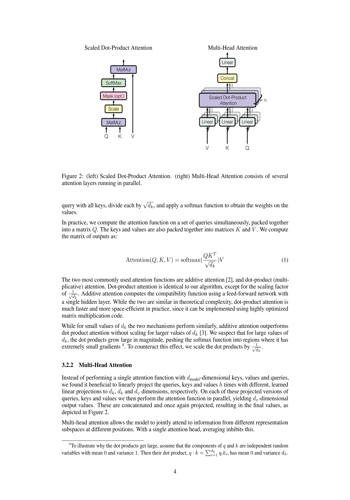

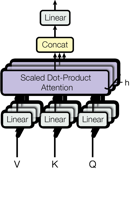

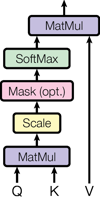

Scaled Dot-Product Attention
Multi-Head Attention
Figure 2: (left) Scaled Dot-Product Attention. (right) Multi-Head Attention consists of several
attention layers running in parallel.
query with all keys, divide each by √dk, and apply a softmax function to obtain the weights on the
values.
In practice, we compute the attention function on a set of queries simultaneously, packed together
into a matrix Q. The keys and values are also packed together into matrices K and V . We compute
the matrix of outputs as:
Attention(Q, K, V ) = softmax(QKT
√dk
)V
(1)
The two most commonly used attention functions are additive attention [2], and dot-product (multi-
plicative) attention. Dot-product attention is identical to our algorithm, except for the scaling factor
of
1
√dk . Additive attention computes the compatibility function using a feed-forward network with
a single hidden layer. While the two are similar in theoretical complexity, dot-product attention is
much faster and more space-efﬁcient i

In [50]:
if RUN_DEV_CELLS:
    show_pdf_page(aiayn.pages[3])

### Not bad. We lost formatting, the formulas are messed up, and we don't know where to place the images in the page. We can clean up the text using Gemini, and use the extracted hi-res images as is, with some extra annotations.

### Let's try with a scanned document that has worse formatting.

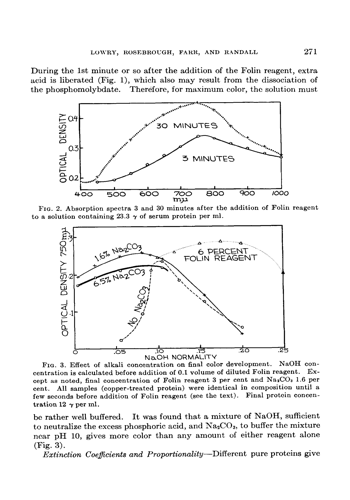

LOWRY, 
ROSEBROUGH, 
FARR, 
AND 
RANDALL 
271 
During 
the 1st minute or so after the addition 
of the Folin reagent, extra 
acid is liberated 
(Fig. 
l), which 
also may result 
from the dissociation 
of 
the phosphomolybdate. 
Thergfore, 
for maximum 
color, the solution 
must 
I 
I 
1 
I 
I 
I 
I 
400 
500 
600 
700 
800 
900 
1000 
mp 
FIG. 
2. Absorption 
spectra 
3 and 
30 minutes 
after 
the 
addition 
of Folin 
reagent 
to a solution 
containing 
23.3 
‘y of serum 
protein 
per 
ml. 
I 
I 
a 
I 
0 
.05 
10 
.15 
.20 
.25 
NaOH 
NORMALITY 
FIG. 
3. Effect 
of alkali 
concentration 
on final 
color 
development. 
NaOH 
con- 
centration 
is calculated 
before 
addition 
of 0.1 volume 
of diluted 
Folin 
reagent. 
Ex- 
cept 
as noted, 
final 
concentration 
of Folin 
reagent 
3 per 
cent 
and 
Na&03 
1.6 per 
cent. 
All 
samples 
(copper-treated 
protein) 
were 
identical 
in composition 
until 
a 
few 
seconds 
before 
addition 
of Folin 
reagent 
(see the 
text). 
Final 
protein 

In [51]:
if RUN_DEV_CELLS:
    lowry = extract_pdf_content("Lowry.pdf")
    show_pdf_page(lowry.pages[6])

### This is a mess. Not only is the text all over the place, the extracted images are just slices of the page.

### We will need to use Gemini to both re-OCR the text, and locate the images in the page.

---

In [52]:
## Handle retries and errors.

def PartType_to_Content(parts: list, role:str = "user"):
        return {
            "role": role,
            "parts": [ to_part(part) for part in parts]
        }

def gemini_generate(model,
                    parts,
                    prefill:str=None,
                    generation_config=None,
                    safety_settings=SAFETY_SETTINGS,
                    retries=MAX_RETRIES):

    messages = PartType_to_Content(parts, role="user")
    if (prefill):
        prefill = PartType_to_Content(prefill, role="model")

    attempts = 0



    while attempts < retries:
        if (attempts > 0):
            warnings.warn(f"Retry {attempts} of maximum {retries}", stacklevel=1)

        response = model.generate_content(
            messages,
            generation_config=generation_config,
            safety_settings=safety_settings,
            request_options=request_options
        )

        
        
        # The call was successful, or we have reached the max tokens.
        # A page should normally not contain this many tokens, but sometimes Gemini gets stuck. :/
        if response.candidates[0].finish_reason in [ Candidate.FinishReason.STOP, Candidate.FinishReason.MAX_TOKENS]:
            tok_in = response.usage_metadata.prompt_token_count
            tok_out = response.usage_metadata.candidates_token_count
            
            if response.candidates[0].finish_reason == Candidate.FinishReason.MAX_TOKENS:
                print(f"Max token reached, the response will be truncated! ({tok_in} tokens in, {tok_out} tokens out)")
            return response.text, tok_in, tok_out


        # Failure cases
        if len(response.candidates) == 0:
            warnings.warn("No candidates received from the model.", stacklevel=1)
            attempts += 1
            continue

        if not response.candidates[0].finish_reason == Candidate.FinishReason.STOP:
            warnings.warn(f"Unexpected finish reason {response.candidates[0].finish_reason.name}", stacklevel=1)
            attempts += 1

    # If we reach here, we have failed all retries.
    if len(response.candidates) == 0:
        raise Exception("No candidates received from the model.")

    if not response.candidates[0].finish_reason == Candidate.FinishReason.STOP:
        raise Exception(f"Unexpected finish reason {response.candidates[0].finish_reason}")

    print(reponse)
    raise Exception("Huh? How did we get here??")

In [53]:
good_enough_prompt="""
You are given a page from a PDF document, and images automatically extracted from it.

First, check if the original page actually has images (figures, plots, diagrams, etc) in it.
If no, return an empty list for the image ratings.
If yes, for all provided images, determine if the image is extracted perfectly.

A perfectly extracted image fully captures one or more figure, plot, or diagram in the page.

Poorly extracted images:
- Extracted image captures only part of a figure, plot, or diagram.
- Extracted image is an image of the full page with mostly text in it.

Be picky.
It's ok if all images are good or bad. Briefly explain your reasoning before making a decision.
"""

# I found that even for this simple task a bit of COT makes a day and night difference.
# The model will generate the values in alphabetical order of the keys, so we need to place reasoning before decision.
class ImageRating(TypedDict):
    a_name: str
    b_reason: str
    c_good: bool

class NeedManualExtraction(TypedDict):
    a_page_has_images: bool
    image_ratings: list[ImageRating]


def analyze_extracted_images(page: PDFPage):
    model = genai.GenerativeModel(model_name=IMAGE_CHECK_MODEL,)

    messages = ["PDF Page:\n", page.page_image]

    if len(page.extracted_images):
        messages.append("Extracted images:\n")
    else:
        messages.append("No images have been extracted from this page, reply with an empty list for image ratings")

    for image in page.extracted_images:
        messages.append(f"Extracted image '{image.name}':\n")
        messages.append(image.image)

    messages.append(good_enough_prompt)

    result, _, _ = gemini_generate(
        model,
        messages,
        generation_config=genai.GenerationConfig(
            max_output_tokens=4000,
            temperature=0,
            top_k=1,
            response_mime_type="application/json",
            response_schema=NeedManualExtraction,
        ),
        safety_settings=SAFETY_SETTINGS,
    )

    page.extracted_images_analyzed = json.loads(result)

In [54]:
if RUN_DEV_CELLS:
    analyze_extracted_images(aiayn.pages[0])
    print("AIAYN no images: " + json.dumps(aiayn.pages[0].extracted_images_analyzed, indent=2))

    analyze_extracted_images(aiayn.pages[3])
    print("AIAYN with good images: " + json.dumps(aiayn.pages[3].extracted_images_analyzed, indent=2))

    analyze_extracted_images(lowry.pages[0])
    print("Lowry no images: " + json.dumps(lowry.pages[0].extracted_images_analyzed, indent=2))

    analyze_extracted_images(lowry.pages[1])
    print("Lowry no images: " + json.dumps(lowry.pages[1].extracted_images_analyzed, indent=2))

    analyze_extracted_images(lowry.pages[6])
    print("Lowry bad images: " + json.dumps(lowry.pages[6].extracted_images_analyzed, indent=2))

AIAYN no images: {
  "a_page_has_images": false,
  "image_ratings": []
}
AIAYN with good images: {
  "a_page_has_images": true,
  "image_ratings": [
    {
      "a_name": "image_2.png",
      "b_reason": "The image is a perfect extraction of the left diagram.",
      "c_good": true
    },
    {
      "a_name": "image_1.png",
      "b_reason": "The image is a perfect extraction of the right diagram.",
      "c_good": true
    }
  ]
}
Lowry no images: {
  "a_page_has_images": false,
  "image_ratings": []
}
Lowry no images: {
  "a_page_has_images": false,
  "image_ratings": []
}
Lowry bad images: {
  "a_page_has_images": true,
  "image_ratings": [
    {
      "a_name": "image_101.png",
      "b_reason": "The extracted image captures only part of the figure.",
      "c_good": false
    },
    {
      "a_name": "image_102.png",
      "b_reason": "The extracted image captures only part of the figure.",
      "c_good": false
    },
    {
      "a_name": "image_103.png",
      "b_reason": "The

### Gemini Flash correctly recognized if a pages has images in it, and for a page with images it correctly recognized if the images are good or not.
### Looks promising. I will assume that the page contains good images if the model gives 👍 for 80%+ of the images

In [55]:
def page_needs_image_extraction(page: PDFPage):
    analyze_extracted_images(page)

    if not page.extracted_images_analyzed.get("a_page_has_images", False):
        # Remove the wrongly extracted images from pages without images to avoid confusing the model later
        page.extracted_image = []
        return False

    good_images = [rating.get("c_good", False) for rating in page.extracted_images_analyzed.get("image_ratings", [])]

    # Sometimes Gemini hallucinates images when given an empry list of extracted images.
    if len(page.extracted_images) < 1:
        return True

    # <= to account for the case where there are images, but none have been extracted.
    if good_images.count(True) <= 0.8 * len(good_images):
        # Images bad overall - remove everything.
        page.extracted_images = []
        return True

    return False

In [56]:
if RUN_DEV_CELLS:
    print(page_needs_image_extraction(aiayn.pages[3]))
    print(page_needs_image_extraction(lowry.pages[6]))

False
True


### Now, if the page needs AI-asisted image extraction...

In [57]:
# I think Gemini prefers this order or coordinates.
image_extraction_prompt = """
Annotate the images in the document with a meaningful caption and a bounding box.
Only provide one annotation for each image. Do not annotate tables.

JSON schema:
[
    {
        a_caption: "Image caption",
        bbox: [top, left, bottom, right]
    },
]
"""

class ImageAnnotation(TypedDict):
    a_caption: str
    bbox: list[int]


def page_find_bboxes(page: PDFPage):
    model = genai.GenerativeModel(model_name=IMAGE_EXTRACTION_MODEL)
    result, _, _ = gemini_generate(
        model,
        [page.page_image, image_extraction_prompt],
        generation_config=genai.GenerationConfig(
            temperature=0,
            top_k=1,
            response_mime_type="application/json",
            response_schema=list[ImageAnnotation],
            max_output_tokens=2000,

        ),
        safety_settings=SAFETY_SETTINGS,
        retries=MAX_RETRIES
    )

    page.images_proposed = []

    # Sanity check the bounding boxes and unswap coordinates if they seem to have been swapped (happens infrequently)
    for image in json.loads(result):
        bbox = image.get("bbox")
        if len(bbox) == 4:
            page.images_proposed.append({
                "a_caption": image.get("a_caption", "unknown"),
                "bbox": [min(bbox[0], bbox[2]), min(bbox[1], bbox[3]), max(bbox[0], bbox[2]), max(bbox[1], bbox[3])]
            })

In [58]:
if RUN_DEV_CELLS:
    page_find_bboxes(lowry.pages[6])

In [59]:
from PIL import ImageDraw

def visualize_bboxes(page: PDFPage):
    img = page.page_image.copy()
    draw = ImageDraw.Draw(img)

    colors = ["red", "green", "blue", "yellow", "purple", "orange", "pink", "brown", "cyan", "magenta"]
    width, height = img.size

    for i, bbox in enumerate([image["bbox"] for image in page.images_proposed]):
        # The order of coordintes is different in PIL
        bbox_img = [
            bbox[1] * width / 1000,   # xmin
            bbox[0] * height / 1000,  # ymin
            bbox[3] * width / 1000,   # xmax
            bbox[2] * height / 1000,  # ymax
        ]
        draw.rectangle(bbox_img, outline=colors[i % len(colors)], width=5)

    return img

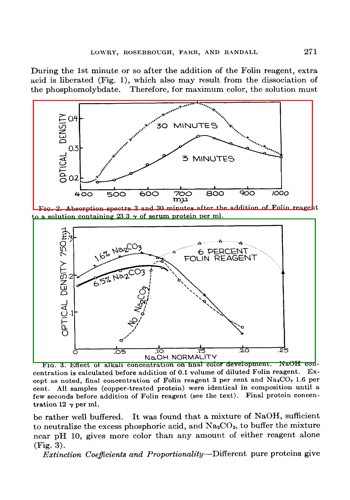

In [60]:
if RUN_DEV_CELLS:
    display(visualize_bboxes(lowry.pages[6]).resize((350, 500)))

### It's not perfect, but might be good enough.

> I tried adding more bboxes that are shifted/scaled around the predicted one, extracting the images and asking Gemini to score how well they are cropped, but for some reason Gemini had a very hard time figuring out which ones had the best crop.

I will scale up the bbox by 15% and hope it captures the whole image.
A dedicated fine-tuned object detection model would give better results, but let's stick to the challenge.


> Note: Right now Gemini seems to do a good job. For some reason, the same model was giving me bboxes that were just a tad too small.  
> I'll leave bbox scaling as is, in case it makes the same mistake for other pages.

In [61]:
def scale_bbox(bbox: list[int], scale):
    assert(len(bbox) == 4)

    ymin, xmin, ymax, xmax = bbox

    width = xmax - xmin
    height = ymax - ymin

    center_x = (xmin + xmax) / 2
    center_y = (ymin + ymax) / 2

    scaled_width = width * scale
    scaled_height = height * scale

    scale_bbox = [
        center_y - scaled_height/2, center_x - scaled_width/2,
        center_y + scaled_height/2, center_x + scaled_width/2
    ]

    return [max(0, min(1000, int(x))) for x in scale_bbox]

def page_scale_bboxes(page: PDFPage, scale):
    for image in page.images_proposed:
        image["bbox"] = scale_bbox(image["bbox"], scale)

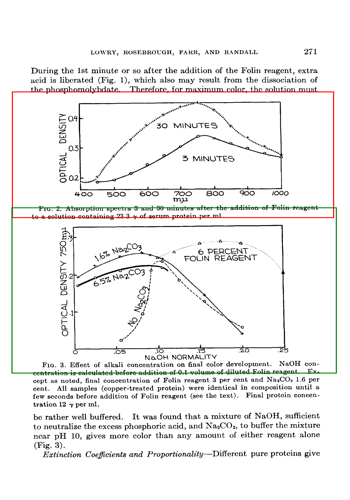

In [62]:
if RUN_DEV_CELLS:
    page_scale_bboxes(lowry.pages[6], 1.15)
    display(visualize_bboxes(lowry.pages[6]).resize((350, 500)))

### We get a bit more text around the image, but I think it's a better alternative to cropping the image.

Another solution would be to pass the images with rendered bboxes to Gemini and ask it to adjust the bboxes, but I did not try that.

In [63]:
# Adds the extracted images to the page.

# I will give a random name to extracted images to avoid biasing the model based on the image number.
# Store the names in a list to avoid duplicates.
random_names = []

def extract_images_from_page(page: PDFPage):

    # Drop the previouly extracted bad images.
    page.extracted_images = []

    for bbox in [image["bbox"] for image in page.images_proposed]:
        ymin, xmin, ymax, xmax = bbox
        width, height = page.page_image.size

        bbox_img = page.page_image.crop((
            xmin * width / 1000, ymin * height / 1000,
            xmax * width / 1000, ymax * height / 1000
        ))

        while True:
            random_name = ''.join(random.choices(string.ascii_lowercase + string.digits, k=5))
            if random_name not in random_names:
                random_names.append(random_name)
                break

        page.extracted_images.append(PDFImage(
            image=bbox_img,
            name=f"image_{random_name}.png",
            bbox=bbox,
        ))

In [64]:
if RUN_DEV_CELLS:
    extract_images_from_page(lowry.pages[6])

In [65]:
# Remove the anti-reciting hack.
def remove_recitation_hack(markdown: str):
    return markdown.replace("[end of paragraph]", "")

In [66]:
common_markdown_prompt = """
For images:
<img src="filename" width="x">. Do not rename images.

For text:
Use markdown heading for sections.
2 spaces at the end of a line force a line break.

For tables:
Use markdown tables. Never include images of tables.

For math formulas:
Use markdown formulas `$...$ ` for inline formulas, and block formulas \n$$\n...\n$$\n for block formulas.
Use \\tag{n} if you want to number a block formula.

For chemical formulas:
Use <sub> and <sup>

For figure captions:
Use markdown quotes (> Figure n: caption)

Escape symbols in text that would be wrongly interpreted as markdown (#, $, *, etc)

Insert [end of paragraph] after each paragraph.
"""

page_markdown_prompt = """
You are give an images of a PDF page, its text content, and extracted images (optional).
Convert the page to markdown. Convert all text as is, don't skip any parts, don't change wording.
Ignore purely decorative elements.

If a page contains figures, plots, diagrams, etc and an image for it is provided, include it in markdown.
Place each extracted image roughly where it appears in the page. Avoid breaking sentences to fit images.
"""

prompt = "\n".join(common_markdown_prompt + page_markdown_prompt)


def page_to_markdown(page: PDFPage):
    model = genai.GenerativeModel(model_name=PAGE_TO_MARKDOWN_MODEL)
    image_messages = []
    for img in page.extracted_images:
        image_messages.append(f"Image variant {img.name}:\n")
        image_messages.append(img.image)

    markdown, tok_in, tok_out = gemini_generate(
        model,
        [
            page.page_image,
            f"Extracted page text:\n",
            page.extracted_text,
            "\nExtracted images:\n",
            *image_messages,
            prompt
        ],
        prefill=["```markdown\n"], # Gemini often wraps the output in ```markdown or ```text. I prefill it for consistency.
        generation_config=genai.GenerationConfig(
            temperature=0,
            top_k=1,
            max_output_tokens=4000,
            response_mime_type="text/plain"
        ),
        safety_settings=SAFETY_SETTINGS
    )

    markdown = markdown.strip()
    
    prefix = "```markdown\n"
    suffix = "```"

    if markdown.startswith(prefix):
        markdown = markdown[len(prefix):]
    if markdown.endswith(suffix):
        markdown = markdown[:-len(suffix)]

    page.markdown = remove_recitation_hack(markdown).strip()
    return tok_in, tok_out

In [67]:
## Save the images so we can render them.
def save_markdown_images(page: PDFPage, directory: str="."):
    directory = Path(directory)
    # Save the images mentioned in the markdown
    os.makedirs(directory, exist_ok=True)
    for img in page.extracted_images:
        if (img.name in page.markdown):
            img.image.save(directory / img.name)

In [68]:
# We saved the images in an output dir, but the image references in Markdown don't have this
# prefix. To render markdown in the notebook, I will need to prepend the directory to the image names.

def patch_dir_base(input: string, image_names: list[str], prefix: Path):
    prefix = Path(prefix)

    replacements = { name : str(prefix/name) for name in image_names }
    pattern = '|'.join(map(re.escape, replacements.keys()))
    return re.sub(pattern, lambda m: replacements[m.group()], input)

In [69]:
# I also wrap the markdown in a collapsible element to avoid cluttering the notebook.
def display_markdown(markdown: str, image_names: list[str], prefix: Path):
    display(Markdown(f"<details><summary>Click to expand</summary>\n\n{patch_dir_base(markdown, image_names, prefix)}\n\n</details>"))

In [70]:
# Let's try with the AIAYN page.
if RUN_DEV_CELLS:
    page_to_markdown(aiayn.pages[3])
    save_markdown_images(aiayn.pages[3], "aiayn_dev")
    display_markdown(aiayn.pages[3].markdown, [image.name for image in aiayn.pages[3].extracted_images], "aiayn_dev")
    # print(aiayn.pages[3].markdown)

<details><summary>Click to expand</summary>

## Scaled Dot-Product Attention
<img src="aiayn_dev/image_2.png" width="150">

## Multi-Head Attention
<img src="aiayn_dev/image_1.png" width="250">

> Figure 2: (left) Scaled Dot-Product Attention. (right) Multi-Head Attention consists of several attention layers running in parallel.

In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix $Q$. The keys and values are also packed together into matrices $K$ and $V$. We compute the matrix of outputs as:

$$
\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V  \tag{1}
$$

The two most commonly used attention functions are additive attention [2], and dot-product (multiplicative) attention. Dot-product attention is identical to our algorithm, except for the scaling factor of $\frac{1}{\sqrt{d_k}}$. Additive attention computes the compatibility function using a feed-forward network with a single hidden layer. While the two are similar in theoretical complexity, dot-product attention is much faster and more space-efficient in practice, since it can be implemented using highly optimized matrix multiplication code.

While for small values of $d_k$ the two mechanisms perform similarly, additive attention outperforms dot product attention without scaling for larger values of $d_k$ [3]. We suspect that for large values of $d_k$, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients<sup>4</sup>. To counteract this effect, we scale the dot products by $\frac{1}{\sqrt{d_k}}$.

### 3.2.2 Multi-Head Attention

Instead of performing a single attention function with $d_{\text{model}}$-dimensional keys, values and queries, we found it beneficial to linearly project the queries, keys and values $h$ times with different, learned linear projections to $d_k$, $d_k$ and $d_v$ dimensions, respectively. On each of these projected versions of queries, keys and values we then perform the attention function in parallel, yielding $d_v$-dimensional output values. These are concatenated and once again projected, resulting in the final values, as depicted in Figure 2.

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.

<sup>4</sup>To illustrate why the dot products get large, assume that the components of $q$ and $k$ are independent random variables with mean 0 and variance 1. Then their dot product, $q \cdot k = \sum_{i=1}^{d_k} q_i k_i$, has mean 0 and variance $d_k$.

</details>

### For some reason Gemini decided to put the images under their own sections, but ok otherwise! Let's try with the Lowry page.

In [71]:
if RUN_DEV_CELLS:
    page_to_markdown(lowry.pages[6])
    save_markdown_images(lowry.pages[6], "lowry_dev")
    display_markdown(lowry.pages[6].markdown, [image.name for image in lowry.pages[6].extracted_images], "lowry_dev")
    # print(lowry.pages[6].markdown)

<details><summary>Click to expand</summary>

LOWRY, ROSEBROUGH, FARR, AND RANDALL  271

During the 1st minute or so after the addition of the Folin reagent, extra acid is liberated (Fig. 1), which also may result from the dissociation of the phosphomolybdate. Therefore, for maximum color, the solution must

<img src="lowry_dev/image_kjk8c.png" width="500">

> FIG. 2. Absorption spectra 3 and 30 minutes after the addition of Folin reagent to a solution containing 23.3 γ of serum protein per ml.


<img src="lowry_dev/image_elwkq.png" width="500">

> FIG. 3. Effect of alkali concentration on final color development. NaOH concentration is calculated before addition of 0.1 volume of diluted Folin reagent. Except as noted, final concentration of Folin reagent 3 per cent and Na<sub>2</sub>CO<sub>3</sub> 1.6 per cent. All samples (copper-treated protein) were identical in composition until a few seconds before addition of Folin reagent (see the text). Final protein concentration 12 γ per ml.

be rather well buffered. It was found that a mixture of NaOH, sufficient to neutralize the excess phosphoric acid, and Na<sub>2</sub>CO<sub>3</sub>, to buffer the mixture near pH 10, gives more color than any amount of either reagent alone (Fig. 3).

Extinction Coefficients and Proportionality--Different pure proteins give

</details>

### It looks good too, let's tie it all together!

### Let's process multiple pages in paralle to make it faster.

Note: I'm not sure what's a reasonable number of parallel workers that does not get rate-limited with a free API key.

In [72]:
from concurrent.futures import ThreadPoolExecutor
from functools import partial

def process_single_page(page, master_pbar):
    # pbar = tqdm(desc=f"Page {page.page_num}", total=3)
    
    pbar = progress_bar(range(3), comment="Checking images...")
    pbar.update(0)

    
    
    # pbar.set_postfix_str("Checking images...")
    need_extraction = page_needs_image_extraction(page)
    pbar.update(1)
    if (need_extraction):
        pbar.comment = "Generating BBoxes..."
        pbar.update(1)

        page_find_bboxes(page)
        page_scale_bboxes(page, 1.15)
        extract_images_from_page(page)

    pbar.comment = "Converting to Markdown..."
    pbar.update(2)
    
    tok_in, tok_out = page_to_markdown(page)
    pbar.comment = f"Done, tokens: {tok_in} => {tok_out}"
    pbar.update(3)

    master_pbar.update(master_pbar.last_v + 1)

def pdf_to_markdown(pdf: PDFDocument, max_workers=16):
    master_pbar = progress_bar(range(len(pdf.pages)), comment="Processing pages")
    master_pbar.update(0)
    
    # with tqdm(total=len(pdf.pages), desc="Processing pages", unit="page") as pbar:
    with ThreadPoolExecutor(max_workers=min(len(pdf.pages), max_workers)) as executor:
        process_fn = partial(process_single_page, master_pbar=master_pbar)
        list(executor.map(process_fn, pdf.pages))
    pdf.markdown = remove_recitation_hack("\n\n".join([page.markdown for page in pdf.pages])).strip()

In [73]:
if RUN_DEV_CELLS:
    pdf_to_markdown(lowry)
    for page in lowry.pages:
        save_markdown_images(page, "lowry_dev")

    display_markdown(lowry.markdown, [image.name for page in lowry.pages for image in page.extracted_images], "lowry_dev")

<details><summary>Click to expand</summary>

# PROTEIN MEASUREMENT WITH THE FOLIN PHENOL REAGENT*

BY OLIVER H. LOWRY, NIRA J. ROSEBROUGH, A. LEWIS FARR, AND ROSE J. RANDALL

(From the Department of Pharmacology, Washington University School of Medicine, St. Louis, Missouri)

(Received for publication, May 28, 1951)


Since 1922 when Wu proposed the use of the Folin phenol reagent for the measurement of proteins (1), a number of modified analytical procedures utilizing this reagent have been reported for the determination of proteins in serum (2-6), in antigen-antibody precipitates (7-9), and in insulin (10).



Although the reagent would seem to be recommended by its great sensitivity and the simplicity of procedure possible with its use, it has not found great favor for general biochemical purposes.



In the belief that this reagent, nevertheless, has considerable merit for certain application, but that its peculiarities and limitations need to be understood for its fullest exploitation, it has been studied with regard to effects of variations in pH, time of reaction, and concentration of reactants, permissible levels of reagents commonly used in handling proteins, and interfering substances. Procedures are described for measuring protein in solution or after precipitation with acids or other agents, and for the determination of as little as 0.2 γ of protein.



## Method

Reagents--Reagent A, 2 per cent Na<sub>2</sub>CO<sub>3</sub> in 0.10 N NaOH. Reagent B, 0.5 per cent CuSO<sub>4</sub>.5H<sub>2</sub>O in 1 per cent sodium or potassium tartrate. Reagent C, alkaline copper solution. Mix 50 ml. of Reagent A with 1 ml. of Reagent B. Discard after 1 day. Reagent D, carbonate-copper solution, is the same as Reagent C except for omission of NaOH. Reagent E, diluted Folin reagent. Titrate Folin-Ciocalteu phenol reagent ((11), Eimer and Amend, Fisher Scientific Company, New York) with NaOH to a phenolphthalein end-point. On the basis of this titration dilute the Folin reagent (about 2-fold) to make it 1 N in acid. Working standards may be prepared from human serum diluted 100- to 1000-fold (approximately 700 to 70 γ per ml.). These in turn may be checked against a standard solution of crystalline bovine albumin (Armour and



\* Supported in part by a grant from the American Cancer Society on the recommendation of the Committee on Growth of the National Research Council.



265

# 266 PROTEIN MEASUREMENT WITH FOLIN REAGENT

Company, Chicago); 1 γ is the equivalent of 0.97 γ of serum protein (see below). Dilute solutions of bovine albumin have not proved satisfactory for working standards because of a marked tendency to undergo surface denaturation.

Procedure for Proteins in Solution or Readily Soluble in Dilute Alkali--(Directions are given for a final volume of 1.1 to 1.3 ml., but any multiple or fraction of the volumes given may be employed as desired.)

To a sample of 5 to 100 γ of protein in 0.2 ml. or less in a 3 to 10 ml. test-tube, 1 ml. of Reagent C is added. Mix well and allow to stand for 10 minutes or longer at room temperature. 0.10 ml. of Reagent E is added very rapidly and mixed within a second or two (see below). After 30 minutes or longer, the sample is read in a calorimeter or spectrophotome- ter. For the range 5 to 25 γ of protein per ml. of final volume, it is desirable to make readings at or near λ = 750 mμ, the absorption peak. For stronger solutions, the readings may be kept in a workable range by reading near λ = 500 mμ (Fig. 2). Calculate from a standard curve, and, if necessary, make appropriate correction for differences between the color value of the working standard and the particular proteins being measured (see below).

It is unnecessary to bring all the samples and standards to the same volume before the addition of the alkaline copper reagent, provided cor- rections are made for small differences in final volume. The critical vol- umes are those of the alkaline copper and Folin reagents.

If the protein is present in an already very dilute solution (less than 25 γ per ml.), 0.5 ml. may be mixed with 0.5 ml. of an exactly double strength Reagent C and otherwise treated as above.

Insoluble Proteins, etc.--Many protein precipitates, e.g. tungstate pre- cipitates, will dissolve readily in the alkaline copper reagent. However, after proteins have been precipitated with trichloroacetic or perchloric acid, for example, they will dissolve rather poorly in the 0.1 N alkali of this reagent. They become even harder to dissolve if subsequently ex- tracted with fat solvents, and still more so if dried at 100°.

It is not possible to cover all cases, but the following may be helpful in measuring the protein of acid precipitates. If the amount of protein is not great, so that it is spread rather thinly, it will usually dissolve in ½ hour or so in 1 N NaOH at room temperature. Therefore, one may add, for example, 0.1 ml. of 1 N NaOH to 5 to 100 γ of precipitated protein.

¹ For example, with the Klett colorimeter, transfer 25 to 500 γ of protein in not over 1 ml. volume to a colorimeter tube. Add water if necessary to make 1 ml. Add 5 ml. of Reagent C, and, after 10 minutes, 0.5 ml. of Reagent E. Readings are taken after 30 minutes with the No. 66 filter. If the readings are too high, substi- tute the No. 54 filter for sample, standards, and blanks.

# LOWRY, ROSEBROUGH, FARR, AND RANDALL  267

After ½ hour or more, 1 ml. of Reagent D (no NaOH) is added, followed
after 10 minutes by 0.1 ml. of diluted Folin Reagent E as usual.  

With larger samples, or very stubborn precipitates, it may be necessary
to heat for 10 minutes or more at 100” in 1 N alkali. Although this may
lower the readings, they will be reproducible and can be measured with
similarly treated standards.2  

Microanalysis—With a Beckman spectrophotometer adapted to 0.05
ml. volume (12), as little as 0.2 γ of protein may be measured with reason-
able precision. Aside from reducing the volumes of sample and reagents,
the only necessary change is to use sufficiently slender tubes for the re-
action. If the tubes are too large in diameter, low values will result.  

The following is illustrative of a procedure in which it is desired to pre-
cipitate the protein in order, for example, to measure an acid-soluble con-
stituent of the same specimen. In this example, it is assumed that the
sample volume is negligible. Otherwise a smaller volume of more con-
centrated trichloroacetic acid would be used.  

To the sample containing 0.2 to 3 γ of protein in a tube of 3 mm. inner
diameter and 4 cm. long,3 are added 10 µl. of 5 per cent trichloroacetic
acid.4 After being mixed and centrifuged, 8 µl. of the supernatant fluid
are removed. To the precipitate are added 5 µl. of 8 N NaOH. The
sample is thoroughly mixed by tapping or “buzzing,”5 and is covered

2 Bovine serum albumin is especially difficult to redissolve after precipitation.
Several 40 mg. samples were precipitated with trichloroacetic acid, washed with
alcohol and isopropyl ether, and dried. These samples dissolved very slowly in 2
ml. of 1 N NaOH. However, after standing overnight, the protein appeared to be
nearly all dissolved and aliquots gave readings 97 per cent of those obtained with
non-precipitated samples. Other samples were heated for 30 minutes at 100” in 1
N NaOH. These samples dissolved and the solution turned slightly yellow. The
final readings checked well but were only 82 per cent of those obtained with non-
precipitated samples. Possibly, heating at lower temperature with the 1 N NaOH
would have sufficed, although heating with weaker alkali would not have been effec-
tive, judging from other experience. The use of stronger alkali than 1 N did not
appear to be an improvement.
3 These tubes are cleaned by rinsing with dilute NaOH, boiling in half concen-
trated HNO<sub>3</sub>, and rinsing several times in redistilled water. Filling or emptying
of a beaker full of tubes (tall form of beaker without lip) is accomplished by slow
centrifugation for a few seconds. For emptying, the tubes are transferred upside
down to a second beaker with a false bottom of stainless steel screen. With the slow
centrifugation required beakers will not be broken.
4 Suitable micro pipettes are the Lang-Levy variety (13, 14). For entering these
narrow tubes the bent tip must be especially short and slender.
5 The tube is held at an angle against a rapidly rotating flattened rod or nail.
Any high speed hand tool mounted in a clamp is satisfactory. The contents of the
tube will mix violently without spilling (15). A similar effect may be had with a
commercial rubber-tipped massage vibrator.

268
PROTEIN MEASUREMENT WITH FOLIN REAGENT

with a rubber cap or Parafilm. After 30 minutes, 50 μl. of Reagent D are added and the sample is mixed by “buzzing.” After 10 minutes or more, 5 μl. of diluted Folin Reagent E are added with immediate “buzzing,” and the samples are read after 30 minutes. Standards are perhaps best prepared by precipitating 5 μl. of 5, 10, 20, etc., mg. per cent solutions of serum protein with 5 μl. of 10 per cent trichloroacetic acid, with subsequent treatment as for the other samples.


EXPERIMENTAL

There are two distinct steps which lead to the final color with protein: (a) reaction with copper in alkali, and (b) reduction of the phosphomolybdic-phosphotungstic reagent by the copper-treated protein.


*Reaction with Copper in Alkaline Solution*--The salient features of this reaction follow. (1) The color obtained in the absence of copper is probably attributable entirely to the tyrosine and tryptophan content (16, 17), and this is not greatly increased by alkaline pretreatment ((4-6) and Table I). (2) In the presence of copper, alkaline treatment of proteins results in a 3- to 15-fold increase in color, but, in contrast, the presence of copper has only a small effect on the color obtained with free tyrosine and tryptophan (Herriott (17, 18) and Table I). (3) The reaction with copper, although not instantaneous, is nearly complete in 5 or 10 minutes at room temperature under the prescribed conditions. Heating to 100° or increasing the concentration of alkali accelerates the reaction with copper without changing the final color. (4) Pretreatment with alkali alone does not alter the subsequent reaction with copper in alkaline solution. Even pretreatment for an hour at 60° with 2 N NaOH, or for 5 minutes at 100° with 1 N NaOH, when followed by the usual copper treatment, has almost no effect on subsequent color.² Prolonged heating with strong alkali will, however, decrease the final color.²

Although the alkaline copper reaction and the biuret reaction appear to be related, they are not strictly proportional, nor, with different proteins, is the amount of biuret color directly proportional to the increment caused by copper in the color with the Folin reagent (Table I).

A very small amount of copper is sufficient to give nearly maximum final color (Table II). The action does not appear to be catalytic. Assuming the simple relationship copper + protein ⇌ copper-protein obtains, the data with low copper concentrations may be utilized to calculate an apparent dissociation constant of 3 × 10⁻⁶ mole per liter with a maximum of 1 mole of chromogenic protein-bound copper per 7 or 8 amino acid residues (Table II).

Mehl, Pacovska, and Winzler (19) conclude with Rising and Yang (20) that in the biuret reaction approximately 1 atom of copper is bound for

LOWRY, ROSEBROUGB, FARR, .4ND RANDALL  269


TABLE I

Extinction Coefficients of Proteins Variously Treated

The equivalent extinction coefficient ε<sub>λ</sub> (or 550) is defined as the optical density at λ = 750 (or 550) mμ with 1 atom of N per liter. Nitrogen was measured by the Kjeldahl procedure of Miller and Houghton (24). The biuret color was developed with the reagents of Weichselbaum (25). Source of proteins, crystalline trypsin, crystalline chymotrypsin, and crystalline bovine albumin, Armour and Company, Chicago; cytochrome c, Sigma Chemical Company, St. Louis; crystalline zinc insulin, Eli Lilly and Company, Indianapolis; gelatin, Difco Laboratories, Inc., Detroit; L-tyrosine, Eastman Kodalr Company, Rochester.


| Protein | Copper absent | Alkaline copper treatment | Increment with Cu | Biuret color |
|---|---|---|---|---|
|  | No pretreatment | Alkali* treatment |  |  |  |
| Trypsin | 733 | 910 | 3,600 | 2690 | 26.3 |
| Insulin | 989 | 998 | 3,000 | 2002 | 24.4 |
| Chymotrypsin | 278 | 425 | 2,930 | 2505 | 25.8 |
| Cytochrome c | 703 | 738 | 2,495 | 1757 | † |
| Human serum | 329 | 365 | 2,120 | 1755 | 21.4 |
| Bovine serum albumin | 312 | 358 | 2,050 | 1692 | 21.8 |
| Gelatin | 79 | 78 | 1,145 | 1067 | 18.0 |
| Tyrosine | 13,700 | 13,850 | 15,100 | 1250 |  |

* 30 minutes in 0.1 N NaOH at room temperature before addition of Folin reagent.

† Regular treatment as described under the procedure.

‡ Not valid because of the color of the cytochrome c.  


TABLE II

Color Increments from Small Amounts of Copper

Serum protein concentration, 12.1 γ per ml. K and chromogenic-bound copper (Cu-protein) calculated from K = Cu × protein/Cu-protein = (Cu(total protein − Cu-protein))/Cu-protein = (Cu(maximum ΔO. D.* − ΔO. D.))/ΔO. D. (assuming that chromogenic copper bound to protein is proportioned to ΔO. D.).


| Total Cu | O. D.* at 750 mμ | ΔO. D. | ΔO. D., per cent of maximum Δ | K | Cu-protein† (calculated) |
|---|---|---|---|---|---|
| 10<sup>−7</sup> γ |  |  |  | × 10<sup>−4</sup> |  |
| 0 | 78 |  |  |  |  |
| 8 | 166 | 88 | 42 | 2.9 | 0.05 |
| 20 | 237 | 159 | 76 | 3.0 | 0.10 |
| 40 | 267 | 189 | 91 | 2.8 | 0.12 |
| 2000 | 286 | 208 | 100 |  | 0.13 |

* Optical density.

† Moles per 117 gm. of protein, *i.e.* per amino acid residue.

# 270 PROTEIN MEASUREMENT WITH FOLIN REAGENT

each 4 amino acid residues, and Mehl et al. calculated dissociation constants for the reaction copper + protein * copper-protein averaging 10 times larger than the one reported herein for the formation of Folin-reactive material. Thus, of the total possible sites for copper combination, it would appear that only about half produce significant reduction of the Folin reagent, and that furthermore this fraction has a considerably greater affinity for copper than the rest.


<img src="lowry_dev/image_4ug9j.png" width="500">


> Fig. 1. “Persistence of reactivity” was measured by adding Folin reagent to protein-free alkali; after the given times, copper-treated protein was added in a small volume, and the color at 750 mµ was measured 30 minutes later. “Color development” refers to a sample of serum protein treated in the regular manner. The points on “optical density 448 mµ” are observed (no protein present); the curve is theoretical for a monomolecular reaction with a half time of 8 seconds.




Reduction of Folin Reagent—Three main points may be made as follows: (1) When the Folin reagent is added to the copper-treated protein, maximum color results if the reduction occurs at about pH 10. (2) At this pH the reagent is only reactive for a short time (16). It is for this reason that even a few seconds delay in complete mixing will lessen the amount of color (Fig. 1). The decrease in reactivity of the reagent appears to be a function of the disappearance of the original yellow color of the phosphomolybdate (half time of 8 seconds (Fig. 1)) and is presumably due to dissociation of the phosphate from the molybdate. Surprisingly, the color with protein continues to develop for a number of minutes after the reagent itself has become unreactive to freshly added protein (Fig. 1). Possibly the primary reduction product rearranges, since the absorption spectrum changes in shape between 3 minutes and 30 minutes (Fig. 2). (3)

LOWRY, ROSEBROUGH, FARR, AND RANDALL  271

During the 1st minute or so after the addition of the Folin reagent, extra acid is liberated (Fig. 1), which also may result from the dissociation of the phosphomolybdate. Therefore, for maximum color, the solution must

<img src="lowry_dev/image_kjk8c.png" width="500">

> FIG. 2. Absorption spectra 3 and 30 minutes after the addition of Folin reagent to a solution containing 23.3 γ of serum protein per ml.


<img src="lowry_dev/image_elwkq.png" width="500">

> FIG. 3. Effect of alkali concentration on final color development. NaOH concentration is calculated before addition of 0.1 volume of diluted Folin reagent. Except as noted, final concentration of Folin reagent 3 per cent and Na<sub>2</sub>CO<sub>3</sub> 1.6 per cent. All samples (copper-treated protein) were identical in composition until a few seconds before addition of Folin reagent (see the text). Final protein concentration 12 γ per ml.

be rather well buffered. It was found that a mixture of NaOH, sufficient to neutralize the excess phosphoric acid, and Na<sub>2</sub>CO<sub>3</sub>, to buffer the mixture near pH 10, gives more color than any amount of either reagent alone (Fig. 3).

Extinction Coefficients and Proportionality--Different pure proteins give

272  PROTEIN MEASUREMENT WITH FOLIN REAGENT

different extinction coefficients with the Folin reagent (Table I). The extremes were observed with trypsin and gelatin which differed by a factor of 3 in chromogenicity. It will be seen that without copper much greater differences occur. The variation in chromogenicity must be kept in mind, but it is much less marked with mixtures of proteins as found in various tissues (Table III), and for many purposes is not a serious drawback.
The relation of color to protein concentration is not quite linear (Table IV).

TABLE III
Apparent Protein Content of Whole Tissues (Rabbit) and Tissue Extracts Calculated from Kjeldahl N and from Folin Color

The tissues were homogenized and precipitated with 5 per cent trichloroacetic acid (TCA), and the lipides removed by successive extraction with 0.1 N potassium acetate in ethanol, ethanol, and isopropyl ether. (The purpose of the acetate is to neutralize the acid and prevent solution of some protein in the ethanol.) The N was determined as in Table I. The extinction coefficients were calculated from the N and color of the extracted precipitates.

| Material analyzed | Extracted ppt. | TCA extract | Lipide extracted | Whole tissue | N* €750 |
|---|---|---|---|---|---|
| Brain | Based on N × 6.25  9.5 | 1.08 | 1.05 | 11.8 | 1960 |
|  | “ “ Folin color  9.5 | 0.15 | 0.28 | 9.8 |  |
| Kidney | “ “ N × 6.25  13.9 |  |  | 15.9 | 1865 |
|  | “ “ Folin color  13.9 | 0.30 | 0.21 | 14.5 |  |
| Liver | “ “ N × 6.25  17.1 |  |  | 19.9 | 1875 |
|  | “ “ Folin color  17.1 | 0.49 | 0.28 | 18.0 |  |
| Skeletal muscle | “ “ N × 6.25  17.8 |  |  | 20.1 | 1942 |
|  | “ “ Folin color  17.8 | 0.15 | 0.09 | 18.8 |  |
| Heart | “ “ N × 6.25  13.0 |  |  | 15.3 | 1975 |
|  | “ “ Folin color  13.0 | 0.20 | 0.17 | 13.4† |  |

* See Table I.
† By summation; other values are direct determinations.

Specificity and Interfering Substances—Few substances encountered in biological work cause serious interference. Only a little color was obtained with either acid extracts or the lipides extracted from five different tissues (Table III). Consequently measurements on non-extracted whole tissue would be in error by only 3 to 6 per cent, whereas values based on N determination would be overestimated by 15 to 20 per cent.
Uric acid (16), guanine, and xanthine (21, 22) react with the Folin reagent. Guanine gives about 50 per cent more color than serum protein, weight for weight. The color is not enhanced by copper. Curiously, guanosine does not react appreciably. Hypoxanthine gives no color if purified (21). No more than a trace of color was obtained with adenine, ade-

LOWRY, ROSEBROUGH, FARR, AND RANDALL  273

nosine, cytosine, cytidine, uracil, thymine, or thymidine (see also Funk
and Macallum (22)).

Neither color nor interference with protein color development was ob-
served with the following substances at the given *final* concentrations:
urea (0.5 per cent), guanidine (0.5 per cent), sodium tungstate (0.5 per
cent), sodium sulfate (1 per cent), sodium nitrate (1 per cent), perchloric
acid (0.5 per cent neutralized), trichloroacetic acid (0.5 per cent neutra-
lized), ethyl alcohol (5 per cent), ether (5 per cent), acetone (0.5 per cent),
zinc sulfate (0.1 per cent), barium hydroxide (0.1 per cent).

Most phenols, except nitrophenols, reduce the reagent (16); therefore
thymol and to a lesser degree sulfosalicylic acid interfere, whereas picric


TABLE IV

Measurement of Small Amounts of Protein from Rabbit Brain
Final volume 0.082 ml.

| Optical* den-
sity at 750 mµ | $E^{1\%}_{1 \text{ cm.}}$
at 750 mµ | Protein
|---|---|---|
|  |  | Found | Present |
| 0.038 |  | γ | γ |
| 0.044 |  | 0.13 | 0.16 |
| 0.040 |  | 0.15 | 0.16 |
| 0.089 | 221 | 0.14 | 0.16 |
| 0.095 | 236 | 0.33 | 0.33 |
| 0.091 | 226 | 0.35 | 0.33 |
| 0.184 | 228 | 0.34 | 0.33 |
| 0.191 | 236 | 0.65 | 0.66 |
| 0.191 | 236 | 0.67 | 0.66 |
|  |  |  |  |
| Optical* density
at 750 mµ | $E^{1\%}_{1 \text{ cm.}}$
at 750 mµ | Protein
|---|---|---|
|  |  | Found | Present |
| 0.280 | 229 | γ | γ |
| 0.292 | 236 | 0.98 | 1.00 |
| 0.283 | 233 | 1.03 | 1.00 |
| 0.365 | 227 | 0.99 | 1.00 |
| 0.367 | 228 | 1.30 | 1.32 |
| 0.365 | 227 | 1.31 | 1.32 |
| 0.441 | 219 | 1.32 | 1.32 |
| 0.443 | 220 | 1.60 | 1.66 |
| 0.444 | 221 | 1.62 | 1.66 |
|  |  | 1.61 | 1.66 |

* Corrected for blank.

acid up to 0.1 per cent is permissible. Glycine (0.5 per cent) decreases
the color with protein by 50 per cent. Hydrazine over 0.5 mg. per cent
increases the blank.

Ammonium sulfate greater than 0.15 per cent final concentration de-
creases color development. This is partly due to a decrease in alkalinity,
and up to 0.25 per cent or so can be tolerated if an equivalent amount
of extra alkali is added to the sample. Extra copper does not seem to
help.

Microanalysis—With final volumes less than 0.1 ml., the amount of
color is proportionately less than on the macro scale, especially if the re-
action is carried out in wide tubes. Extensive testing did not definitely
identify the cause of the decreased color. Neither oxygen, carbon dioxide,
nor glass surface seemed to be involved. The critical step is the period
of standing with alkali and copper.

274

PROTEIN MEASUREMENT WITH FOLIN REAGENT

The practical solution to this interesting difficulty seems to be to use slender tubes and to run standards under the same conditions. Table IV illustrates the reproducibility of protein measurements on small brain samples. Rabbit brain was homogenized and diluted 200- to 2000-fold. Aliquots of 3.6 μl. were analyzed for protein at a final volume of 0.082 ml. The amount of protein present was calculated from macro analyses. It is seen that the error is usually not over 0.02 γ.  

DISCUSSION

The measurement of protein with copper and the Folin reagent has certain advantages. (1) It is as sensitive as with Nessler’s reagent, yet requires no digestion. (2) It is 10 or 20 times more sensitive than measurement of the ultraviolet absorption at λ = 280 mμ and is much more specific and much less liable to disturbance by turbidities. (3) It is several fold more sensitive than the ninhydrin reaction (23) and is somewhat simpler, as well as much easier to adapt for small scale analyses. Free amino acids give much more color than proteins with the ninhydrin reaction, whereas the reverse is true with the Folin reagent. (4) It is 100 times more sensitive than the biuret reaction.  

There are two major disadvantages of the Folin reaction. (a) The amount of color varies with different proteins. In this regard it is less constant than the biuret reaction, but more constant than the absorption at λ = 280 mμ. (b) The color is not strictly proportional to concentration.  

From a consideration of the advantages and disadvantages, the reasonable applications of the copper-Folin reaction would seem to include (1) measurement of protein during enzyme fractionations, etc., (2) measurement of mixed tissue proteins, particularly when absolute values are not needed, (3) measurement of very small absolute amounts of protein, or highly diluted protein (e.g., spinal fluid) or protein mixed with colored substances or other nitrogen-containing substances, and (4) analyses of large numbers of similar protein samples, such as antigen-antibody precipitates.  

SUMMARY

1. A study is presented of the measurement of proteins with the Folin phenol reagent after alkaline copper treatment. The basic reactions have certain peculiarities which need to be taken into consideration in using this reagent.  

2. Directions are given for measurement of proteins in solution and proteins which have been precipitated with acid, etc. A micro procedure is also described for the measurement of as little as 0.2 γ of protein.  

3. The differences in the amount of color obtained with a number of proteins is recorded. Interfering substances are listed.

LOWRY, ROSEBROUGH, FARR, AND RANDALL  275

4. The advantages of simplicity and sensitivity of this reaction recommend it for a number of biochemical purposes.


BIBLIOGRAPHY

1. Wu, H., *J. Biol. Chem.*, **51**, 33 (1922).
2. Wu, H., and Ling, S. M., *Chinese J. Physiol.*, **1**, 161 (1927).
3. Greenberg, D. M., *J. Biol. Chem.*, **82**, 545 (1929).
4. Andersch, M., and Gibson, R. B., *J. Lab. and Clin. Med.*, **18**, 816 (1933).
5. Greenberg, D. M., and Mirolubova, T. N., *J. Lab. and Clin. Med.*, **21**, 431 (1936).
6. Minot, A. S., and Keller, M., *J. Lab. and Clin. Med.*, **21**, 743 (1936).
7. Pressman, D., *Ind. and Eng. Chem., Anal. Ed.*, **15**, 357 (1943).
8. Heidelberger, M., and MacPherson, C. F. C., *Science*, **97**, 405 (1943).
9. Kabat, E. A., and Mayer, M. M., *Experimental immunochemistry*, Springfield, 321 (1948).
10. Sutherland, E. W., Cori, C. F., Haynes, R., and Olsen, N. S., *J. Biol. Chem.*, **180**, 825 (1949).
11. Folin, O., and Ciocalteu, V., *J. Biol. Chem.*, **73**, 627 (1927).
12. Lowry, O. H., and Bessey, O. A., *J. Biol. Chem.*, **163**, 633 (1946).
13. Levy, M., *Compt.-rend. trav. Lab. Carlsberg, Série chim.*, **21**, 101 (1945).
14. Bessey, O. A., Lowry, O. H., and Brock, M. J., *J. Biol. Chem.*, **164**, 321 (1946).
15. Bessey, O. A., Lowry, O. H., Brock, M. J., and Lopez, J. A., *J. Biol. Chem.*, **166**, 177 (1946).
16. Folin, O., and Denis, W., *J. Biol. Chem.*, **12**, 239 (1912).
17. Herriott, R. M., *J. Gen. Physiol.*, **19**, 283 (1935).
18. Herriott, R. M., *Proc. Soc. Exp. Biol. and Med.*, **46**, 642 (1941).
19. Mehl, J. W., Pacovska, E., and Winzler, R. J., *J. Biol. Chem.*, **177**, 13 (1949).
20. Rising, M. M., and Yang, P. S., *J. Biol. Chem.*, **99**, 755 (1932-33).
21. Hitchings, G. H., *J. Biol. Chem.*, **139**, 843 (1941).
22. Funk, C., and Macallum, A. B., *Biochem. J.*, **7**, 356 (1913).
23. Kunkel, H. G., and Ward, S. M., *J. Biol. Chem.*, **182**, 597 (1950).
24. Miller, L., and Houghton, J. A., *J. Biol. Chem.*, **159**, 373 (1945).
25. Weichselbaum, T. E., *Am. J. Clin. Path.*, **16**, Tech. Sect., 10, 40 (1946).

</details>

### Looks OK. Now let's do a second pass.

Gemini did a decent job at converting individual pages to PDF, but it made a couple mistakes because for each pages it did not have access to othe pages. It also inserted a non-exiting "image.png" for some reason.
I will pass the whole document through Gemini again, to improve consistency between pages, brush up formatting, and optionally will make links to bibliography work properly.

---

### If we process the entire document, and we need to use a few tricks:
- It's possible the whole document will not fit into the output token limit (8K), so we need to generate the output in steps.
- Cache the input (whole document + page images + extracted images) to save cost.

In [74]:
## Handle caching, multi-step generation, retries, and errors.

# For debugging purposes:

multistep_log = []

def gemini_generate_multistep(model,
                    messages,
                    prefill: str,
                    pbar,
                    max_total_chars=None,  # We might want to limit the length of generated text to avoid an infinite loop.
                    generation_config=None,
                    safety_settings=SAFETY_SETTINGS,
                    retries=MAX_RETRIES):


    pbar.comment = "Caching input..."
    pbar.update(0)
    
    # if pbar: pbar.set_postfix_str("Caching input...")

    attempts = 0

    while attempts < retries:
        try: 
            # Here we are find with passing the messages array, since we don't need to pass a dict.
            cache = caching.CachedContent.create(
                model=model.model_name,
                contents=messages,
                ttl=datetime.timedelta(hours=1), # We will delete the cache manually after we are done.
            )
            cache_model = genai.GenerativeModel.from_cached_content(cache)
            break
        except Exception:
            delay = 5 ** attempts
            print(f"Got an error creating cache, exponential backoff (attempt {attempts} of {retries}) after {delay} seconds...")
            sleep(delay)
            attempts += 1

    multistep_log.append({"msg": "Cachd input", "cache": cache, "cached_messages": messages})

    attempts = 0
    multistep_count = 1
    # Gemini requires at least one message besides cache. Luckily we always start with a markdown block.
    
    try:
        while attempts < retries:
            pbar.comment = f"Generaring content... (step {multistep_count})"
            pbar.update(pbar.last_v)
            if (attempts > 0):
                delay = 5 ** attempts
                print(f"Got an error, exponential backoff (attempt {attempts} of {retries}) after {delay} seconds...")
                sleep(delay)

            response = cache_model.generate_content(
                [{"role": "model", "parts": [{"text": prefill}]}],
                generation_config=generation_config,
                safety_settings=safety_settings,
                request_options=request_options
            )

            if len(response.candidates) == 0:
                multistep_log.append({
                    "mdg": "Received no candidates",
                    "response": response,
                    "input": messages,
                    "extra": prefill,
                })
                print("No candidates received from the model, see multistep_log for details.", file=sys.stderr)
                attempts += 1
                continue

            if response.candidates[0].finish_reason == Candidate.FinishReason.STOP:
                tok_in = response.usage_metadata.prompt_token_count
                tok_cached = response.usage_metadata.cached_content_token_count
                tok_out = response.usage_metadata.candidates_token_count
                
                pbar.total = (len(prefill + response.text))
                pbar.comment = f"Done. Last step tokens: {tok_in} ({tok_cached} cached) in, {tok_out} out"
                pbar.update(len(prefill + response.text))

                multistep_log.append({
                    "msg": "Finished",
                    "extra": [{"role": "model", "parts": [{"text": prefill}]}],
                    "text": response.text,
                    "reason": response.candidates[0].finish_reason.name,
                    "cache": cache,
                    })

                return prefill + response.text, response.usage_metadata


            if response.candidates[0].finish_reason == Candidate.FinishReason.MAX_TOKENS:
                multistep_count += 1
                val = pbar.last_v + len(response.text)
                if pbar.total < val: pbar.total = val + 1
                pbar.update(val)
                
                attempts = 0
                prefill += response.text

                multistep_log.append({
                    "msg": "MAX_TOKENS reached",
                    "extra": [{"role": "model", "parts": [{"text": prefill}]}],
                    "text": response.text,
                    "reason": response.candidates[0].finish_reason.name,
                    "cache": cache,
                    })


                # We don't want the model to get stuck in an infinite loop.
                # We will limit the total number of characters generated, with a small extra margin.
                if max_total_chars is not None and len(prefill + response.text) > max_total_chars + 1000:
                    print("Max total characters reached.")
                    response_text = prefill + response.text
                    pbar.comment = "Max total characters reached"
                    pbar.update(len(response_text))
                    return response_text, response.usage_metadata
                else:
                    continue

            # We can only reach here if the finish reason is not STOP or MAX_TOKENS.
            multistep_log.append({
                "msg": "Unexpected finish reason",
                "extra": [{"role": "model", "parts": [{"text": prefill}]}],
                "reason": response.candidates[0].finish_reason.name,
                "cache": cache,
                "response": response
                })
            print(f"Unexpected finish reason: {response.candidates[0].finish_reason.name}")
            attempts += 1


        # If we reach here, we have failed all retries.
        print("Max retries reached")
        print(response)
        raise Exception("Max retries reached.")

    finally:
        if cache:
            attempts = 0
            while attempts < retries:
                try:
                    cache.delete()
                    break
                except Exception:
                    delay = 5 ** attempts
                    print(f"Got an error deleting cache, exponential backoff (attempt {attempts} of {retries}) after {delay} seconds...")
                    sleep(delay)
                    attempts += 1

                    

In [75]:
brush_it_up_prompt = """
Improve formatting in this markdown document.

Never change the wording or structure of the document.
Never summarize, even parts that are long and repetitive.
Never remove images, tables, or other content.

If the text has special symbols that would be incorrectly interpreted as markdown formatting, escape them.

Output markdown only.
"""

prompt = "\n".join([brush_it_up_prompt, common_markdown_prompt])


def brush_it_up(document: PDFDocument, max_tokens=1000, max_retries=MAX_RETRIES):

    pbar = progress_bar(range(len(document.markdown)))
    pbar.update(0)
    
    model = genai.GenerativeModel(model_name=SECOND_PASS_MODEL)
    if not document.markdown:
        print("The document is missing markdown!")
        return

    messages = []
    # for page in document.pages:
    #     messages.append(f"Page: {page.page_num}\n")
    #     messages.append(page.page_image)

    messages.append(f"Document:\n```markdonw\n{document.markdown}\n```")
    # messages.append(f"Available images: {[image.name for page in document.pages for image in page.extracted_images if image.name in document.markdown]}. Remove ireferences to mages that are not in this list")
    messages.append(f"Instructions:\n{prompt}")

    multistep_log = []
    multistep_log.append({"msg": "Brush it up", "messages": messages, "document": document})

    markdown, usage = gemini_generate_multistep(
                model,
                messages,
                prefill="```markdown\n", # Gemini often wraps the output in ```markdown or ```text. I prefill it for consistency.
                # We don't want to create an infinite loop, and 1.5 the input size give a good safety margin.
                max_total_chars=len(document.markdown) * 1.5,
                pbar=pbar,
                generation_config=genai.GenerationConfig(
                    max_output_tokens=max_tokens,
                    temperature=0,
                    top_k=1,
                    response_mime_type="text/plain"),
            )


    markdown = markdown.strip()
    prefix = "```markdown\n"
    suffix = "```"

    if markdown.startswith(prefix):
        markdown = markdown[len(prefix):]
    if markdown.endswith(suffix):
        markdown = markdown[:-len(suffix)]

    return remove_recitation_hack(markdown).strip(), usage

In [76]:
if RUN_DEV_CELLS:
    md, usage = brush_it_up(lowry, 2000)
    display_markdown(md, [image.name for page in lowry.pages for image in page.extracted_images], "lowry_dev")
    print(f"Usage on the last call:\n{usage}")

<details><summary>Click to expand</summary>

# PROTEIN MEASUREMENT WITH THE FOLIN PHENOL REAGENT*

BY OLIVER H. LOWRY, NIRA J. ROSEBROUGH, A. LEWIS FARR, AND ROSE J. RANDALL

(From the Department of Pharmacology, Washington University School of Medicine, St. Louis, Missouri)

(Received for publication, May 28, 1951)


Since 1922 when Wu proposed the use of the Folin phenol reagent for the measurement of proteins (1), a number of modified analytical procedures utilizing this reagent have been reported for the determination of proteins in serum (2-6), in antigen-antibody precipitates (7-9), and in insulin (10). 


Although the reagent would seem to be recommended by its great sensitivity and the simplicity of procedure possible with its use, it has not found great favor for general biochemical purposes. 


In the belief that this reagent, nevertheless, has considerable merit for certain application, but that its peculiarities and limitations need to be understood for its fullest exploitation, it has been studied with regard to effects of variations in pH, time of reaction, and concentration of reactants, permissible levels of reagents commonly used in handling proteins, and interfering substances.  Procedures are described for measuring protein in solution or after precipitation with acids or other agents, and for the determination of as little as 0.2 γ of protein. 


## Method

Reagents--Reagent A, 2 per cent Na<sub>2</sub>CO<sub>3</sub> in 0.10 N NaOH. Reagent B, 0.5 per cent CuSO<sub>4</sub>·5H<sub>2</sub>O in 1 per cent sodium or potassium tartrate. Reagent C, alkaline copper solution. Mix 50 ml. of Reagent A with 1 ml. of Reagent B. Discard after 1 day. Reagent D, carbonate-copper solution, is the same as Reagent C except for omission of NaOH. Reagent E, diluted Folin reagent. Titrate Folin-Ciocalteu phenol reagent ((11), Eimer and Amend, Fisher Scientific Company, New York) with NaOH to a phenolphthalein end-point. On the basis of this titration dilute the Folin reagent (about 2-fold) to make it 1 N in acid. Working standards may be prepared from human serum diluted 100- to 1000-fold (approximately 700 to 7 γ per ml.). These in turn may be checked against a standard solution of crystalline bovine albumin (Armour and  


\* Supported in part by a grant from the American Cancer Society on the recommendation of the Committee on Growth of the National Research Council. 


265

# 266 PROTEIN MEASUREMENT WITH FOLIN REAGENT

Company, Chicago); 1 γ is the equivalent of 0.97 γ of serum protein (see below). Dilute solutions of bovine albumin have not proved satisfactory for working standards because of a marked tendency to undergo surface denaturation. 

Procedure for Proteins in Solution or Readily Soluble in Dilute Alkali--(Directions are given for a final volume of 1.1 to 1.3 ml., but any multiple or fraction of the volumes given may be employed as desired.) 

To a sample of 5 to 100 γ of protein in 0.2 ml. or less in a 3 to 10 ml. test-tube, 1 ml. of Reagent C is added. Mix well and allow to stand for 10 minutes or longer at room temperature. 0.10 ml. of Reagent E is added very rapidly and mixed within a second or two (see below). After 30 minutes or longer, the sample is read in a calorimeter or spectrophotometer. For the range 5 to 25 γ of protein per ml. of final volume, it is desirable to make readings at or near λ = 750 mμ, the absorption peak. For stronger solutions, the readings may be kept in a workable range by reading near λ = 500 mμ (Fig. 2). Calculate from a standard curve, and, if necessary, make appropriate correction for differences between the color value of the working standard and the particular proteins being measured (see below). 

It is unnecessary to bring all the samples and standards to the same volume before the addition of the alkaline copper reagent, provided corrections are made for small differences in final volume. The critical volumes are those of the alkaline copper and Folin reagents. 

If the protein is present in an already very dilute solution (less than 25 γ per ml.), 0.5 ml. may be mixed with 0.5 ml. of an exactly double strength Reagent C and otherwise treated as above. 

Insoluble Proteins, etc.--Many protein precipitates, e.g. tungstate precipitates, will dissolve readily in the alkaline copper reagent. However, after proteins have been precipitated with trichloroacetic or perchloric acid, for example, they will dissolve rather poorly in the 0.1 N alkali of this reagent. They become even harder to dissolve if subsequently extracted with fat solvents, and still more so if dried at 100°. 

It is not possible to cover all cases, but the following may be helpful in measuring the protein of acid precipitates. If the amount of protein is not great, so that it is spread rather thinly, it will usually dissolve in ½ hour or so in 1 N NaOH at room temperature. Therefore, one may add, for example, 0.1 ml. of 1 N NaOH to 5 to 100 γ of precipitated protein. 

¹ For example, with the Klett colorimeter, transfer 25 to 500 γ of protein in not over 1 ml. volume to a colorimeter tube. Add water if necessary to make 1 ml. Add 5 ml. of Reagent C, and, after 10 minutes, 0.5 ml. of Reagent E. Readings are taken after 30 minutes with the No. 66 filter. If the readings are too high, substitute the No. 54 filter for sample, standards, and blanks. 

# LOWRY, ROSEBROUGH, FARR, AND RANDALL  267

After ½ hour or more, 1 ml. of Reagent D (no NaOH) is added, followed
after 10 minutes by 0.1 ml. of diluted Folin Reagent E as usual.  

With larger samples, or very stubborn precipitates, it may be necessary
to heat for 10 minutes or more at 100° in 1 N alkali. Although this may
lower the readings, they will be reproducible and can be measured with
similarly treated standards.<sup>2</sup>  

Microanalysis—With a Beckman spectrophotometer adapted to 0.05
ml. volume (12), as little as 0.2 γ of protein may be measured with reasonable precision. Aside from reducing the volumes of sample and reagents,
the only necessary change is to use sufficiently slender tubes for the reaction. If the tubes are too large in diameter, low values will result.  

The following is illustrative of a procedure in which it is desired to precipitate the protein in order, for example, to measure an acid-soluble constituent of the same specimen. In this example, it is assumed that the sample volume is negligible. Otherwise a smaller volume of more concentrated trichloroacetic acid would be used.  

To the sample containing 0.2 to 3 γ of protein in a tube of 3 mm. inner
diameter and 4 cm. long,<sup>3</sup> are added 10 µl. of 5 per cent trichloroacetic acid.<sup>4</sup> After being mixed and centrifuged, 8 µl. of the supernatant fluid
are removed. To the precipitate are added 5 µl. of 8 N NaOH. The
sample is thoroughly mixed by tapping or “buzzing,”<sup>5</sup> and is covered 

<sup>2</sup> Bovine serum albumin is especially difficult to redissolve after precipitation.
Several 40 mg. samples were precipitated with trichloroacetic acid, washed with
alcohol and isopropyl ether, and dried. These samples dissolved very slowly in 2
ml. of 1 N NaOH. However, after standing overnight, the protein appeared to be
nearly all dissolved and aliquots gave readings 97 per cent of those obtained with
non-precipitated samples. Other samples were heated for 30 minutes at 100° in 1
N NaOH. These samples dissolved and the solution turned slightly yellow. The
final readings checked well but were only 82 per cent of those obtained with non-
precipitated samples. Possibly, heating at lower temperature with the 1 N NaOH
would have sufficed, although heating with weaker alkali would not have been effective, judging from other experience. The use of stronger alkali than 1 N did not
appear to be an improvement. 

<sup>3</sup> These tubes are cleaned by rinsing with dilute NaOH, boiling in half concentrated HNO<sub>3</sub>, and rinsing several times in redistilled water. Filling or emptying
ofa beaker full of tubes (tall form of beaker without lip) is accomplished by slow
centrifugation for a few seconds. For emptying, the tubes are transferred upside
down to a second beaker with a false bottom of stainless steel screen. With the slow
centrifugation required beakers will not be broken. 

<sup>4</sup> Suitable micro pipettes are the Lang-Levy variety (13, 14). For entering these
narrow tubes the bent tip must be especially short and slender. 

<sup>5</sup> The tube is held at an angle against a rapidly rotating flattened rod or nail.
Any high speed hand tool mounted in a clamp is satisfactory. The contents of the
tube will mix violently without spilling (15). A similar effect may be had with a
commercial rubber-tipped massage vibrator. 

268
PROTEIN MEASUREMENT WITH FOLIN REAGENT

with a rubber cap or Parafilm. After 30 minutes, 50 μl. of Reagent D are added and the sample is mixed by “buzzing.” After 10 minutes or more, 5 μl. of diluted Folin Reagent E are added with immediate “buzzing,” and the samples are read after 30 minutes. Standards are perhaps best prepared by precipitating 5 μl. of 5, 10, 20, etc., mg. per cent solutions of serum protein with 5 μl. of 10 per cent trichloroacetic acid, with subsequent treatment as for the other samples. 


## EXPERIMENTAL

There are two distinct steps which lead to the final color with protein: (a) reaction with copper in alkali, and (b) reduction of the phosphomolybdic-phosphotungstic reagent by the copper-treated protein. 


### Reaction with Copper in Alkaline Solution

The salient features of this reaction follow. (1) The color obtained in the absence of copper is probably attributable entirely to the tyrosine and tryptophan content (16, 17), and this is not greatly increased by alkaline pretreatment ((4-6) and Table I). (2) In the presence of copper, alkaline treatment of proteins results in a 3- to 15-fold increase in color, but, in contrast, the presence of copper has only a small effect on the color obtained with free tyrosine and tryptophan (Herriott (17, 18) and Table I). (3) The reaction with copper, although not instantaneous, is nearly complete in 5 or 10 minutes at room temperature under the prescribed conditions. Heating to 100° or increasing the concentration of alkali accelerates the reaction with copper without changing the final color. (4) Pretreatment with alkali alone does not alter the subsequent reaction with copper in alkaline solution. Even pretreatment for an hour at 60° with 2 N NaOH, or for 5 minutes at 100° with 1 N NaOH, when followed by the usual copper treatment, has almost no effect on subsequent color.<sup>2</sup> Prolonged heating with strong alkali will, however, decrease the final color.<sup>2</sup> 

Although the alkaline copper reaction and the biuret reaction appear to be related, they are not strictly proportional, nor, with different proteins, is the amount of biuret color directly proportional to the increment caused by copper in the color with the Folin reagent (Table I). 

A very small amount of copper is sufficient to give nearly maximum final color (Table II). The action does not appear to be catalytic. Assuming the simple relationship copper + protein ⇌ copper-protein obtains, the data with low copper concentrations may be utilized to calculate an apparent dissociation constant of 3 × 10⁻⁶ mole per liter with a maximum of 1 mole of chromogenic protein-bound copper per 7 or 8 amino acid residues (Table II). 

Mehl, Pacovska, and Winzler (19) conclude with Rising and Yang (20) that in the biuret reaction approximately 1 atom of copper is bound for 

Table I

Extinction Coefficients of Proteins Variously Treated

The equivalent extinction coefficient $\epsilon_{\lambda}$ (or 550) is defined as the optical density at $\lambda$ = 750 (or 550) mμ with 1 atom of N per liter. Nitrogen was measured by the Kjeldahl procedure of Miller and Houghton (24). The biuret color was developed with the reagents of Weichselbaum (25). Source of proteins, crystalline trypsin, crystalline chymotrypsin, and crystalline bovine albumin, Armour and Company, Chicago; cytochrome c, Sigma Chemical Company, St. Louis; crystalline zinc insulin, Eli Lilly and Company, Indianapolis; gelatin, Difco Laboratories, Inc., Detroit; L-tyrosine, Eastman Kodak Company, Rochester.


| Protein | Copper absent | Alkaline copper treatment | Increment with Cu | Biuret color |
|---|---|---|---|---|
|  | No pretreatment | Alkali* treatment |  |  |  |
| Trypsin | 733 | 910 | 3,600 | 2690 | 26.3 |
| Insulin | 989 | 998 | 3,000 | 2002 | 24.4 |
| Chymotrypsin | 278 | 425 | 2,930 | 2505 | 25.8 |
| Cytochrome c | 703 | 738 | 2,495 | 1757 |  |
| Human serum | 329 | 365 | 2,120 | 1755 | 21.4 |
| Bovine serum albumin | 312 | 358 | 2,050 | 1692 | 21.8 |
| Gelatin | 79 | 78 | 1,145 | 1067 | 18.0 |
| Tyrosine | 13,700 | 13,850 | 15,100 | 1250 |  |

* 30 minutes in 0.1 N NaOH at room temperature before addition of Folin reagent.

  


Table II

Color Increments from Small Amounts of Copper

Serum protein concentration, 12.1 γ per ml. K and chromogenic-bound copper (Cu-protein) calculated from K = Cu × protein/Cu-protein = (Cu(total protein − Cu-protein))/Cu-protein = (Cu(maximum ΔO. D.* − ΔO. D.))/ΔO. D. (assuming that chromogenic copper bound to protein is proportioned to ΔO. D.).


| Total Cu | O. D.* at 750 mμ | ΔO. D. | ΔO. D., per cent of maximum Δ | K | Cu-protein† (calculated) |
|---|---|---|---|---|---|
| 10<sup>−7</sup> γ |  |  |  | × 10<sup>−4</sup> |  |
| 0 | 78 |  |  |  |  |
| 8 | 166 | 88 | 42 | 2.9 | 0.05 |
| 20 | 237 | 159 | 76 | 3.0 | 0.10 |
| 40 | 267 | 189 | 91 | 2.8 | 0.12 |
| 2000 | 286 | 208 | 100 |  | 0.13 |

* Optical density.

† Moles per 117 gm. of protein, *i.e.* per amino acid residue.



LOWRY, ROSEBROUGH, FARR, AND RANDALL  269


each 4 amino acid residues, and Mehl et al. calculated dissociation constants for the reaction copper + protein ⇌ copper-protein averaging 10 times larger than the one reported herein for the formation of Folin-reactive material. Thus, of the total possible sites for copper combination, it would appear that only about half produce significant reduction of the Folin reagent, and that furthermore this fraction has a considerably greater affinity for copper than the rest. 


<img src="lowry_dev/image_4ug9j.png" width="500">

> Figure 1: “Persistence of reactivity” was measured by adding Folin reagent to protein-free alkali; after the given times, copper-treated protein was added in a small volume, and the color at 750 mµ was measured 30 minutes later. “Color development” refers to a sample of serum protein treated in the regular manner. The points on “optical density 448 mµ” are observed (no protein present); the curve is theoretical for a monomolecular reaction with a half time of 8 seconds.


### Reduction of Folin Reagent

Three main points may bemade as follows: (1) When the Folin reagent is added to the copper-treated protein, maximum color results if the reduction occurs at about pH 10. (2) At this pH the reagent is only reactive for a short time (16). It is for this reason that even a few seconds delay in complete mixing will lessen the amount of color (Fig. 1). The decrease in reactivity of the reagent appears to be a function of the disappearance of the original yellow color of the phosphomolybdate (half time of 8 seconds (Fig. 1)) and is presumably due to dissociation of the phosphate from the molybdate. Surprisingly, the color with protein continues to develop for a number of minutes after the reagent itself has become unreactive to freshly added protein (Fig. 1). Possibly the primary reduction product rearranges, since the absorption spectrum changes in shape between 3 minutes and 30 minutes (Fig. 2). (3) 

<img src="lowry_dev/image_kjk8c.png" width="500">

> Figure 2: Absorption spectra 3 and 30 minutes after the addition of Folin reagent to a solution containing 23.3 γ of serum protein per ml.


<img src="lowry_dev/image_elwkq.png" width="500">

> Figure 3: Effect of alkali concentration on final color development. NaOH concentration is calculated before addition of 0.1 volume of diluted Folin reagent. Except as noted, final concentration of Folin reagent 3 per cent and Na<sub>2</sub>CO<sub>3</sub> 1.6 per cent. All samples (copper-treated protein) were identical in composition until a few seconds before addition of Folin reagent (see the text). Final protein concentration 12 γ per ml.


During the 1<sup>st</sup> minute or so after the addition of the Folin reagent, extra acid is liberated (Fig. 1), which also may result from the dissociation of the phosphomolybdate. Therefore, for maximum color, the solution must 

be rather well buffered. It was found that a mixture of NaOH, sufficient to neutralize the excess phosphoric acid, and Na<sub>2</sub>CO<sub>3</sub>, to buffer the mixture near pH 10, gives more color than any amount of either reagent alone (Fig. 3). 

### Extinction Coefficients and Proportionality

Different pure proteins give 

different extinction coefficients with the Folin reagent (Table I). The extremes were observed with trypsin and gelatin which differed by a factor of 3 in chromogenicity. It will be seen that without copper much greater differences occur. The variation in chromogenicity must be kept in mind, but it is much less marked with mixtures of proteins as found in various tissues (Table III), and for many purposes is not a serious drawback. 
The relation of color to protein concentration is not quite linear (Table IV). 

Table III
Apparent Protein Content of Whole Tissues (Rabbit) and Tissue Extracts Calculated from Kjeldahl N and from Folin Color

The tissues were homogenized and precipitated with 5 per cent trichloroacetic acid (TCA), and the lipides removed by successive extraction with 0.1 N potassium acetate in ethanol, ethanol, and isopropyl ether. (The purpose of the acetate is to neutralize the acid and prevent solution of some protein in the ethanol.) The N was determined as in Table I. The extinction coefficients were calculated from the N and color of the extracted precipitates.

| Material analyzed | Extracted ppt. | TCA extract | Lipide extracted | Whole tissue | N* €750 |
|---|---|---|---|---|---|
| Brain | Based on N × 6.25  9.5 | 1.08 | 1.05 | 11.8 | 1960 |
|  | “ “ Folin color  9.5 | 0.15 | 0.28 | 9.8 |  |
| Kidney | “ “ N × 6.25  13.9 |  |  | 15.9 | 1865 |
|  | “ “ Folin color  13.9 | 0.30 | 0.21 | 14.5 |  |
| Liver | “ “ N × 6.25  17.1 |  |  | 19.9 | 1875 |
|  | “ “ Folin color  17.1 | 0.49 | 0.28 | 18.0 |  |
| Skeletal muscle | “ “ N × 6.25  17.8 |  |  | 20.1 | 1942 |
|  | “ “ Folin color  17.8 | 0.15 | 0.09 | 18.8 |  |
| Heart | “ “ N × 6.25  13.0 |  |  | 15.3 | 1975 |
|  | “ “ Folin color  13.0 | 0.20 | 0.17 | 13.4† |  |

* See Table I.
† By summation; other values are direct determinations.



### Specificity and Interfering Substances

Few substances encountered in biological work cause serious interference. Only a little color was obtained with either acid extracts or the lipides extracted from five different tissues (Table III). Consequently measurements on non-extracted whole tissue would be in error by only 3 to 6 per cent, whereas values based on N determination would be overestimated by 15 to 20 per cent. 
Uric acid (16), guanine, and xanthine (21, 22) react with the Folin reagent. Guanine gives about 50 per cent more color than serum protein, weight for weight. The color is not enhanced by copper. Curiously, guanosine does not react appreciably. Hypoxanthine gives no color if purified (21). No more than a trace of color was obtained with adenine, adenosine, cytosine, cytidine, uracil, thymine, or thymidine (see also Funk and Macallum (22)). 

Neither color nor interference with protein color development was observed with the following substances at the given final concentrations: urea (0.5 per cent), guanidine (0.5 per cent), sodium tungstate (0.5 per cent), sodium sulfate (1 per cent), sodium nitrate (1 per cent), perchloric acid (0.5 per cent neutralized), trichloroacetic acid (0.5 per cent neutralized), ethyl alcohol (5 per cent), ether (5 per cent), acetone (0.5 per cent), zinc sulfate (0.1 per cent), barium hydroxide (0.1 per cent). 

Most phenols, except nitrophenols, reduce the reagent (16); therefore thymol and to a lesser degree sulfosalicylic acid interfere, whereas picric 


Table IV

Measurement of Small Amounts of Protein from Rabbit Brain
Final volume 0.082 ml.

| Optical* density at 750 mµ | $E^{1\%}_{1 \text{ cm.}}$ at 750 mµ | Protein |
|---|---|---|
|  |  | Found | Present |
| 0.038 |  | γ | γ |
| 0.044 |  | 0.13 | 0.16 |
| 0.040 |  | 0.15 | 0.16 |
| 0.089 | 221 | 0.14 | 0.16 |
| 0.095 | 236 | 0.33 | 0.33 |
| 0.091 | 226 | 0.35 | 0.33 |
| 0.184 | 228 | 0.34 | 0.33 |
| 0.191 | 236 | 0.65 | 0.66 |
| 0.191 | 236 | 0.67 | 0.66 |
|  |  |  |  |
| Optical* density at 750 mµ | $E^{1\%}_{1 \text{ cm.}}$ at 750 mµ | Protein |
|---|---|---|
|  |  | Found | Present |
| 0.280 | 229 | γ | γ |
| 0.292 | 236 | 0.98 | 1.00 |
| 0.283 | 233 | 1.03 | 1.00 |
| 0.365 | 227 | 0.99 | 1.00 |
| 0.acid up to 0.1 per cent is permissible. Glycine (0.5 per cent) decreases
the color with protein by 50 per cent. Hydrazine over 0.5 mg. per cent
increases the blank. 

Ammonium sulfate greater than 0.15 per cent final concentration decreases color development. This is partly due to a decrease in alkalinity, and up to 0.25 per cent or so can be tolerated if an equivalent amount of extra alkali is added to the sample. Extra copper does not seem to help. 

### Microanalysis

With final volumes less than 0.1 ml., the amount of color is proportionately less than on the macro scale, especially if the reaction is carried out in wide tubes. Extensive testing did not definitely identify the cause of the decreased color. Neither oxygen, carbon dioxide, nor glass surface seemed to be involved. The critical step is the period of standing with alkali and copper. 

The practical solution to this interesting difficulty seems to be to use slender tubes and to run standards under the same conditions. Table IV illustrates the reproducibility of protein measurements on small brain samples. Rabbit brain was homogenized and diluted 200- to 2000-fold. Aliquots of 3.6 μl. were analyzed for protein at a final volume of 0.082 ml. The amount of protein present was calculated from macro analyses. It is seen that the error is usually not over 0.02 γ.  


## DISCUSSION

The measurement of protein with copper and the Folin reagent has certain advantages. (1) It is as sensitive as with Nessler’s reagent, yet requires no digestion. (2) It is 10 or 20 times more sensitive than measurement of the ultraviolet absorption at λ = 280 mμ and is much more specific and much less liable to disturbance by turbidities. (3) It is several fold more sensitive than the ninhydrin reaction (23) and is somewhat simpler, as well as much easier to adapt for small scale analyses. Free amino acids give much more color than proteins with the ninhydrin reaction, whereas the reverse is true with the Folin reagent. (4) It is 100 times more sensitive than the biuret reaction.  

There are two major disadvantages of the Folin reaction. (a) The amount of color varies with different proteins. In this regard it is less constant than the biuret reaction, but more constant than the absorption at λ = 280 mμ. (b) The color is not strictly proportional to concentration.  

From a consideration of the advantages and disadvantages, the reasonable applications of the copper-Folin reaction would seem to include (1) measurement of protein during enzyme fractionations, etc., (2) measurement of mixed tissue proteins, particularly when absolute values are not needed, (3) measurement of very small absolute amounts of protein, or highly diluted protein (e.g., spinal fluid) or protein mixed with colored substances or other nitrogen-containing substances, and (4) analyses of large numbers of similar protein samples, such as antigen-antibody precipitates.  


## SUMMARY

1. A study is presented of the measurement of proteins with the Folin phenol reagent after alkaline copper treatment. The basic reactions have certain peculiarities which need to be taken into consideration in using this reagent.  

2. Directions are given for measurement of proteins in solution and proteins which have been precipitated with acid, etc. A micro procedure is also described for the measurement of as little as 0.2 γ of protein.  

3. The differences in the amount of color obtained with a number of proteins is recorded. Interfering substances are listed. 

4. The advantages of simplicity and sensitivity of this reaction recommend it for a number of biochemical purposes. 


## BIBLIOGRAPHY

1. Wu, H., *J. Biol. Chem.*, **51**, 33 (1922). 
2. Wu, H., and Ling, S. M., *Chinese J. Physiol.*, **1**, 161 (1927). 
3. Greenberg, D. M., *J. Biol. Chem.*, **82**, 545 (1929). 
4. Andersch, M., and Gibson, R. B., *J. Lab. and Clin. Med.*, **18**, 816 (1933). 
5. Greenberg, D. M., and Mirolubova, T. N., *J. Lab. and Clin. Med.*, **21**, 431 (1936). 
6. Minot, A. S., and Keller, M., *J. Lab. and Clin. Med.*, **21**, 743 (1936). 
7. Pressman, D., *Ind. and Eng. Chem., Anal. Ed.*, **15**, 357 (1943). 
8. Heidelberger, M., and MacPherson, C. F. C., *Science*, **97**, 405 (1943). 
9. Kabat, E. A., and Mayer, M. M., *Experimental immunochemistry*, Springfield, 321 (1948). 
10. Sutherland, E. W., Cori, C. F., Haynes, R., and Olsen, N. S., *J. Biol. Chem.*, **180**, 825 (1949). 
11. Folin, O., and Ciocalteu, V., *J. Biol. Chem.*, **73**, 627 (1927). 
12. Lowry, O. H., and Bessey, O. A., *J. Biol. Chem.*, **163**, 633 (1946). 
13. Levy, M., *Compt.-rend. trav. Lab. Carlsberg, Série chim.*, **21**, 101 (1945). 
14. Bessey, O. A., Lowry, O. H., and Brock, M. J., *J. Biol. Chem.*, **164**, 321 (1946). 
15. Bessey, O. A., Lowry, O. H., Brock, M. J., and Lopez, J. A., *J. Biol. Chem.*, **166**, 177 (1946). 
16. Folin, O., and Denis, W., *J. Biol. Chem.*, **12**, 239 (1912). 
17. Herriott, R. M., *J. Gen. Physiol.*, **19**, 283 (1935). 
18. Herriott, R. M., *Proc. Soc. Exp. Biol. and Med.*, **46**, 642 (1941). 
19. Mehl, J. W., Pacovska, E., and Winzler, R. J., *J. Biol. Chem.*, **177**, 13 (1949). 
20. Rising, M. M., and Yang, P. S., *J. Biol. Chem.*, **99**, 755 (1932-33). 
21. Hitchings, G. H., *J. Biol. Chem.*, **139**, 843 (1941). 
22. Funk, C., and Macallum, A. B., *Biochem. J.*, **7**, 356 (1913). 
23. Kunkel, H. G., and Ward, S. M., *J. Biol. Chem.*, **182**, 597 (1950). 
24. Miller, L., and Houghton, J. A., *J. Biol. Chem.*, **159**, 373 (1945). 
25. Weichselbaum, T. E., *Am. J. Clin. Path.*, **16**, Tech. Sect., 10, 40 (1946).

</details>

Usage on the last call:
prompt_token_count: 14107
candidates_token_count: 1931
total_token_count: 16038
cached_content_token_count: 8104



### This looks very nice!
### Gemini fixed up a few inconsistencies between pages and correctly escaped all markdown syntax in text
### Let's tie  it all together!

In [77]:
def convert_pdf_to_markdown(pdf_path: str, output_dir: str= "output", second_pass=True, max_tokens=2000, max_workers=16):
    output_dir = Path(output_dir)

    document = extract_pdf_content(pdf_path)
    pdf_to_markdown(document, max_workers=max_workers)
    os.makedirs(output_dir, exist_ok=True)
    for page in document.pages:
        save_markdown_images(page, output_dir)
    if second_pass:
        open(output_dir / "document-preliminary.md", "w").write(document.markdown)
        document.markdown_pass1 = document.markdown
        document.markdown, usage = brush_it_up(document, max_tokens=max_tokens)
        open(output_dir / "document-final.md", "w").write(document.markdown)
        print(f"Usage on the last call:\n{usage}")
    else:
        open(output_dir / "document.md", "w").write(document.markdown)
    return document

In [ ]:
if RUN_DEV_CELLS:
    aiayn = convert_pdf_to_markdown("AIAYN.pdf", "aiayn")
    display_markdown(aiayn.markdown, [image.name for page in aiayn.pages for image in page.extracted_images], "aiayn")

## This used 18K tokens of input context.
## The competition requires us to use at least 100k context. I will convert the Gemini 1 paper (just because it's smaller than Gemini 1.5), which is 90 pages long.

In [ ]:
# This take a really long time to run.

if RUN_DEV_CELLS and RUN_SUPER_LONG_CONTEXT:
    multistep_log = []
    gemini = convert_pdf_to_markdown("gemini.pdf", "gemini", second_pass=True)

### 115K input tokens. Let's take a look.

In [ ]:
display_markdown(gemini.markdown, [image.name for page in gemini.pages for image in page.extracted_images], "gemini")

### Now the final touch - a simple UI

Note: The UI does not work in Kaggle! Use colab or run it locally!

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import shutil
import tempfile
import base64

In [ ]:
upload = widgets.FileUpload(accept='.pdf', multiple=False)
second_pass=widgets.Checkbox(description="Two passes (slow but better results)",
                             disabled=True,
                             indent=False,
                             value=True)
parallel=widgets.Checkbox(description="Paralel processing (might rate-limit free API keys)",
                             disabled=True,
                             indent=False,
                             value=True)
convert_btn = widgets.Button(description='Convert to Markdown', disabled=True)
status = widgets.HTML(value='')
download_btn = widgets.Button(description='Download Results', disabled=True)
download_link = widgets.HTML()
show_btn = widgets.Button(description='Display the document', disabled=True, value=False)

container = widgets.VBox()

# temp_dir = Path(tempfile.mkdtemp(dir="/kaggle/working")).relative_to(Path.cwd())
temp_dir = Path(tempfile.mkdtemp(dir="."))

input_path = None
prefix = None
filename = None

def on_upload_change(change):
    global input_path

    global prefix
    global filename
    if upload.value:

        if widgets.__version__ < "8.0.0":
            value = list(upload.value.values())[0]
            filename = value["metadata"]["name"]
            file_content = value['content']
        else:
            value = upload.value[0]
            filename = value["name"]
            file_content = value['content']


        # Save uploaded file
        input_path = temp_dir/filename
        with open(input_path, 'wb') as f:
            f.write(file_content)

        # Convert
        prefix = temp_dir/'output'
        os.makedirs(prefix, exist_ok=True)

        # Enable conversion when a file is uploaded.
        parallel.disabled = False
        second_pass.disabled = False
        convert_btn.disabled = False


zip_filename = None
document = None
def on_convert_click(b):
        global zip_filename
        global document

        convert_btn.disabled=True
        try:
            document = convert_pdf_to_markdown(input_path,
                                               prefix,
                                               second_pass.value,
                                               parallel.value)

            # Create zip
            zip_filename = f'{filename}-output.zip'
            zip_path = temp_dir/zip_filename
            shutil.make_archive(str(zip_path)[:-4], 'zip', prefix)

            # Enable download and show
            download_btn.disabled = False
            show_btn.disabled = False
            status.value = '<span style="color: green">Conversion complete!</span>'
        except Exception as e:
            download_btn.disabled = True
            status.value = f'<span style="color: red">Error: {str(e)}</span>'
        convert_btn.disabled=True


def on_download_click(b):
    with open(os.path.join(temp_dir, zip_filename), 'rb') as f:
        content = f.read()
        b64 = base64.b64encode(content).decode()
    download_link.value = f"""
    <a download="{zip_filename}"
       href="data:application/zip;base64,{b64}"
       target="_blank">Click to download</a>
    """

markdown_display_handle = None

def on_show_click(b):
    global markdown_display_handle
    display(Markdown(patch_dir_base(document, prefix)), display_id=True)

upload.observe(on_upload_change, names='value')
convert_btn.on_click(on_convert_click)
download_btn.on_click(on_download_click)
show_btn.on_click(on_show_click)



container.children = [upload, status, second_pass, parallel, convert_btn, download_btn, download_link, show_btn]

# Display UI
display(container)

## Note: The UI does not work in Kaggle. Run it on Colab or locally!

### Run the cell above to reset it